# Download all the dependencies

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import io
from io import BytesIO


#!conda update -n base -c defaults conda
import json 
from pandas.io.json import json_normalize 

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
from folium import plugins

# Foursquare credentials

In [91]:
CLIENT_ID = 'ORNMTH1LZTW0XD3DHMMGAM1C0XOMR3BLUNLB3A5JPB2OK3M0' 
CLIENT_SECRET = 'UUI5UZEWSTWTUNAETAVYTTJ5C2MRR3ALB5DOPQD3JVTVJAHY' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ORNMTH1LZTW0XD3DHMMGAM1C0XOMR3BLUNLB3A5JPB2OK3M0
CLIENT_SECRET:UUI5UZEWSTWTUNAETAVYTTJ5C2MRR3ALB5DOPQD3JVTVJAHY


# Functions to gather data from Foursquare API

In [92]:
# get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=600
    LIMIT=150
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json() # get all the data
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_nyc_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json() # all data is in features label
    
    features=resp['features'] # define the dataframe columns
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    nyc_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        nyc_data = nyc_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return nyc_data

# Geographic data of New York

In [4]:
nyc_data = get_nyc_data()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
nyc_data.shape

(306, 4)

# Plot Number of Neighborhood for each Borough in New York

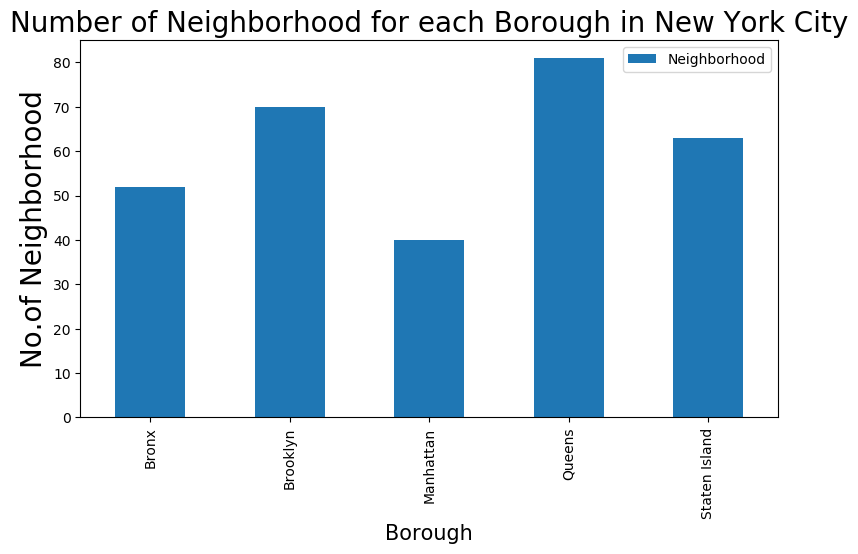

In [140]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=20)
nyc_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

# Create data frame for number of coffee shop per Borough using foursquare api

In [7]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
nyc_coffee=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee_shop=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(nyc_data),')','Coffee Shop in '+Neighborhood+', '+Borough+':'+str(len(coffee_shop)))
    print(row)
    for rest_detail in coffee_shop.values.tolist():
        id, name , category=rest_detail
        nyc_coffee = nyc_coffee.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
  

( 1 / 306 ) Coffee Shop in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Coffee Shop in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Coffee Shop in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Coffee Shop in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Coffee Shop in Riverdale, Bronx:1
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Coffee Shop in Kingsbridge, Bronx:2
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Coffee Shop in Marble Hill, Manhattan:2
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Coffee Shop in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Coffee Shop in Norwood, Bronx:1
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 / 306 ) Co

( 72 / 306 ) Coffee Shop in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Coffee Shop in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Coffee Shop in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Coffee Shop in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Coffee Shop in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 / 306 ) Coffee Shop in Mill Island, Brooklyn:0
['Brooklyn', 'Mill Island', 40.606336421685626, -73.90818571777423]
( 78 / 306 ) Coffee Shop in Manhattan Beach, Brooklyn:0
['Brooklyn', 'Manhattan Beach', 40.57791350308657, -73.94353722891886]
( 79 / 306 ) Coffee Shop in Coney Island, Brooklyn:0
['Brooklyn', 'Coney Island', 40.57429256471601, -73.98868295821637]
( 80 / 306 ) Coffee Shop in Bath 

( 140 / 306 ) Coffee Shop in Long Island City, Queens:9
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Coffee Shop in Sunnyside, Queens:2
['Queens', 'Sunnyside', 40.74017628351924, -73.92691617561577]
( 142 / 306 ) Coffee Shop in East Elmhurst, Queens:1
['Queens', 'East Elmhurst', 40.76407323883091, -73.86704147658772]
( 143 / 306 ) Coffee Shop in Maspeth, Queens:0
['Queens', 'Maspeth', 40.725427374093606, -73.89621713626859]
( 144 / 306 ) Coffee Shop in Ridgewood, Queens:0
['Queens', 'Ridgewood', 40.70832315613858, -73.90143517559589]
( 145 / 306 ) Coffee Shop in Glendale, Queens:1
['Queens', 'Glendale', 40.70276242967838, -73.87074167435605]
( 146 / 306 ) Coffee Shop in Rego Park, Queens:2
['Queens', 'Rego Park', 40.72897409480735, -73.8578268690537]
( 147 / 306 ) Coffee Shop in Woodhaven, Queens:0
['Queens', 'Woodhaven', 40.68988687915789, -73.8581104655432]
( 148 / 306 ) Coffee Shop in Ozone Park, Queens:0
['Queens', 'Ozone Park', 40.68070846826

( 210 / 306 ) Coffee Shop in New Springville, Staten Island:2
['Staten Island', 'New Springville', 40.594252379161695, -74.16496031329827]
( 211 / 306 ) Coffee Shop in Travis, Staten Island:0
['Staten Island', 'Travis', 40.58631375103281, -74.19073717538116]
( 212 / 306 ) Coffee Shop in New Dorp, Staten Island:1
['Staten Island', 'New Dorp', 40.57257231820632, -74.1164794360638]
( 213 / 306 ) Coffee Shop in Oakwood, Staten Island:0
['Staten Island', 'Oakwood', 40.5584622432888, -74.12156593771896]
( 214 / 306 ) Coffee Shop in Great Kills, Staten Island:0
['Staten Island', 'Great Kills', 40.549480228713605, -74.14932381490992]
( 215 / 306 ) Coffee Shop in Eltingville, Staten Island:1
['Staten Island', 'Eltingville', 40.542230747450745, -74.1643308041936]
( 216 / 306 ) Coffee Shop in Annadale, Staten Island:0
['Staten Island', 'Annadale', 40.53811417474507, -74.17854866165878]
( 217 / 306 ) Coffee Shop in Woodrow, Staten Island:1
['Staten Island', 'Woodrow', 40.541967622888755, -74.20524

( 276 / 306 ) Coffee Shop in Stuyvesant Town, Manhattan:1
['Manhattan', 'Stuyvesant Town', 40.73099955477061, -73.97405170469203]
( 277 / 306 ) Coffee Shop in Flatiron, Manhattan:3
['Manhattan', 'Flatiron', 40.739673047638426, -73.9909471052826]
( 278 / 306 ) Coffee Shop in Sunnyside Gardens, Queens:3
['Queens', 'Sunnyside Gardens', 40.74565180608076, -73.91819286431682]
( 279 / 306 ) Coffee Shop in Blissville, Queens:0
['Queens', 'Blissville', 40.73725071694497, -73.93244235260178]
( 280 / 306 ) Coffee Shop in Fulton Ferry, Brooklyn:3
['Brooklyn', 'Fulton Ferry', 40.70328109093014, -73.99550751888415]
( 281 / 306 ) Coffee Shop in Vinegar Hill, Brooklyn:3
['Brooklyn', 'Vinegar Hill', 40.70332149882874, -73.98111603592393]
( 282 / 306 ) Coffee Shop in Weeksville, Brooklyn:0
['Brooklyn', 'Weeksville', 40.67503986503237, -73.93053108817338]
( 283 / 306 ) Coffee Shop in Broadway Junction, Brooklyn:0
['Brooklyn', 'Broadway Junction', 40.67786104769531, -73.90331684852599]
( 284 / 306 ) Coff

In [8]:
nyc_coffee.shape

(380, 4)

# Save data to csv file to limit Foursquare calls

In [9]:
nyc_coffee.to_csv ('nyc_coffee.csv')

In [10]:
nyc_coffee = r'nyc_coffee.csv'
nyc_coffee = pd.read_csv(nyc_coffee)
nyc_coffee.drop(['Unnamed: 0'], axis=1, inplace = True)

In [11]:
nyc_coffee.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,49d73e8ff964a5201f5d1fe3,Starbucks
1,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine
2,Bronx,Kingsbridge,55f81cd2498ee903149fcc64,Starbucks
3,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks
4,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks


# Plot Number of Coffee shops for each Borough in New York

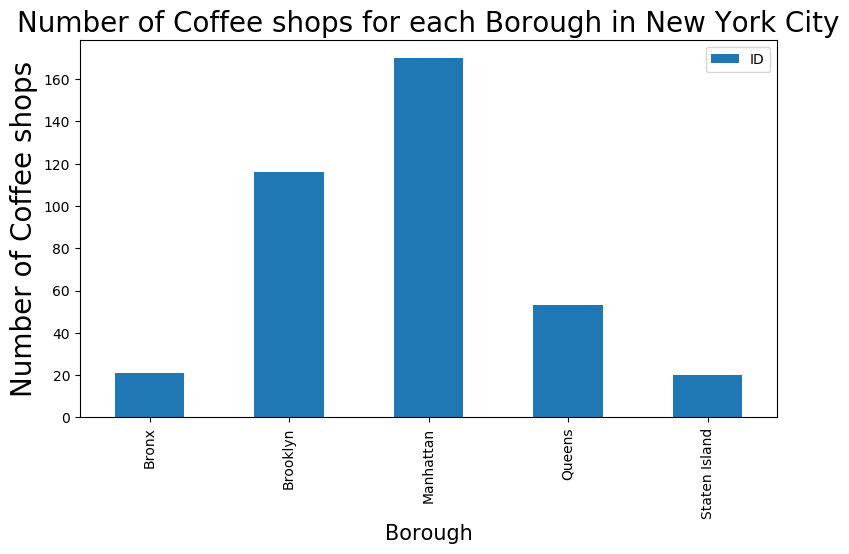

In [141]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Coffee shops for each Borough in New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Coffee shops', fontsize=20)
nyc_coffee.groupby('Borough')['ID'].count().plot.bar
plt.legend()
plt.show()

# Create dataframe for Manhattan and save to csv file

In [78]:
column_names = ['Borough', 'Neighborhood', 'ID', 'Name']
manhattan_coffee = pd.DataFrame(columns=column_names)

In [79]:
manhattan = nyc_coffee.groupby('Borough')
manhattan_coffee = manhattan.get_group('Manhattan')

In [80]:
manhattan_coffee.tail()

,Borough,Neighborhood,ID,Name
356,Manhattan,Flatiron,5825eee5282ffc2b5fab9cd3,Gasoline Alley Coffee
375,Manhattan,Hudson Yards,5c683caaf96b2c00397a8609,Oslo Coffee Roasters
376,Manhattan,Hudson Yards,59ca57dd3d47910ad148e668,Bluestone Lane
377,Manhattan,Hudson Yards,526d9114498ec8efda93fcce,Romeo and Juliet Coffee
378,Manhattan,Hudson Yards,5dd83fae6690dd00088cb92f,Starbucks


In [81]:
manhattan_coffee.shape

(170, 4)

In [82]:
manhattan_coffee.to_csv ('manhattan_coffee.csv')

In [83]:
manhattan_coffee = r'manhattan_coffee.csv'
manhattan_coffee = pd.read_csv(manhattan_coffee)
manhattan_coffee.drop(['Unnamed: 0'], axis=1, inplace = True)

In [84]:
manhattan_coffee.shape

(170, 4)

In [86]:
manhattan_coffee.head()

,Borough,Neighborhood,ID,Name
0,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks
1,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks
2,Manhattan,Chinatown,579f74eb498e9a4d6caabeda,Little Canal
3,Manhattan,Chinatown,4df7603c7d8b5f396ac5cfd5,Cafe Grumpy
4,Manhattan,Washington Heights,5bafd8419de23b002c772a72,Forever Coffee Bar


# Plot  Number of Coffee shops for Top 5 Neighborhood in Manhattan

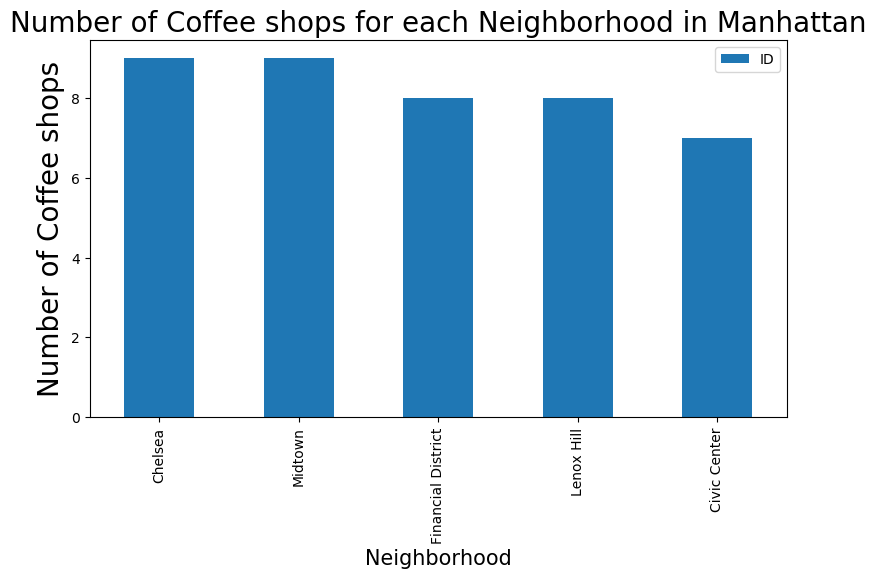

In [122]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Coffee shops for each Neighborhood in Manhattan', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Number of Coffee shops', fontsize=20)
manhattan_coffee.groupby('Neighborhood')['ID'].count().nlargest(5).plot.bar
plt.legend()
plt.show()

# Create Manhattan Dataframe with Latitude and Longitude and save to csv file

In [125]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
manhattan_data = pd.DataFrame(columns=column_names)

In [126]:
m_data=nyc_data.groupby('Borough')
manhattan_data = m_data.get_group('Manhattan')
manhattan_data.tail()

,Borough,Neighborhood,Latitude,Longitude
273,Manhattan,Turtle Bay,40.752042,-73.967708
274,Manhattan,Tudor City,40.746917,-73.971219
275,Manhattan,Stuyvesant Town,40.731000,-73.974052
276,Manhattan,Flatiron,40.739673,-73.990947
301,Manhattan,Hudson Yards,40.756658,-74.000111


In [127]:
manhattan_data.shape

(40, 4)

In [128]:
manhattan_data.to_csv ('manhattan_data.csv')

In [129]:
manhattan_data = r'manhattan_data.csv'
manhattan_data = pd.read_csv(manhattan_data)
manhattan_data.drop(['Unnamed: 0'], axis=1, inplace = True)

In [130]:
manhattan_data.tail()

,Borough,Neighborhood,Latitude,Longitude
35,Manhattan,Turtle Bay,40.752042,-73.967708
36,Manhattan,Tudor City,40.746917,-73.971219
37,Manhattan,Stuyvesant Town,40.731000,-73.974052
38,Manhattan,Flatiron,40.739673,-73.990947
39,Manhattan,Hudson Yards,40.756658,-74.000111


In [131]:
manhattan_data.shape

(40, 4)

# Create data frame for ratings of coffee shop in Manhattan using foursquare api and save to csv file

In [93]:
#make a call to Foursquare API to get Likes and Rating 

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating']
manhattan_rate=pd.DataFrame(columns=column_names)
count=1
for row in manhattan_coffee.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating=venue_details.values.tolist()[0]
    except IndexError:
        #print('No data available for id=',ID) #assign 0 value for the restaurants as they may have been
                                            #recently opened or details do not exist in the FourSquare Database
        id,name,likes,rating=[0]*4                                                                                   
    print('(',count,'/',len(manhattan_coffee),')','processed')
    manhattan_rate = manhattan_rate.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                },ignore_index=True)
                                                                                             
                                        
                                               
    count+=1

{'meta': {'code': 200, 'requestId': '5e97ed3283525f001b3dd932'}, 'response': {'venue': {'id': '55f81cd2498ee903149fcc64', 'name': 'Starbucks', 'contact': {'phone': '6464559846', 'formattedPhone': '(646) 455-9846', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '171 W 230th St', 'crossStreet': 'Kimberly Pl', 'lat': 40.87753134921497, 'lng': -73.90558216359267, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87753134921497, 'lng': -73.90558216359267}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 W 230th St (Kimberly Pl)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/55f81cd2498ee903149fcc64', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '5e97ecc4e826ac001b0f8808'}, 'response': {'venue': {'id': '579f74eb498e9a4d6caabeda', 'name': 'Little Canal', 'contact': {'phone': '9174727479', 'formattedPhone': '(917) 472-7479', 'instagram': 'littlecanal'}, 'location': {'address': '26 Canal St', 'crossStreet': 'at Essex St', 'lat': 40.714317, 'lng': -73.990361, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714317, 'lng': -73.990361}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['26 Canal St (at Essex St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-canal/579f74eb498e9a4d6caabeda', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', '

{'meta': {'code': 200, 'requestId': '5e97ed1669babe001b9172a8'}, 'response': {'venue': {'id': '4df7603c7d8b5f396ac5cfd5', 'name': 'Cafe Grumpy', 'contact': {'phone': '2122603454', 'formattedPhone': '(212) 260-3454'}, 'location': {'address': '13 Essex St', 'crossStreet': 'btwn Hester & Canal St', 'lat': 40.71506878269568, 'lng': -73.98995222774947, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71506878269568, 'lng': -73.98995222774947}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 Essex St (btwn Hester & Canal St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-grumpy/4df7603c7d8b5f396ac5cfd5', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': 

{'meta': {'code': 200, 'requestId': '5e97ed8a618f43001bd8b3a4'}, 'response': {'venue': {'id': '5bafd8419de23b002c772a72', 'name': 'Forever Coffee Bar', 'contact': {}, 'location': {'address': '714 W 181st St', 'lat': 40.85043253392718, 'lng': -73.93660674414312, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85043253392718, 'lng': -73.93660674414312}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['714 W 181st St', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/forever-coffee-bar/5bafd8419de23b002c772a72', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 11, 'gr

{'meta': {'code': 200, 'requestId': '5e97ed1eb1cac0001bbed7e8'}, 'response': {'venue': {'id': '5c092ec2d1a402002cd083cb', 'name': 'Kuro Kirin', 'contact': {}, 'location': {'address': '4795 Broadway', 'lat': 40.866223, 'lng': -73.925691, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866223, 'lng': -73.925691}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4795 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kuro-kirin/5c092ec2d1a402002cd083cb', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5e97ec5b95feaf001b3294fc'}, 'response': {'venue': {'id': '55aa54bc498eac980f832bc9', 'name': 'Monkey Cup', 'contact': {}, 'location': {'address': '1730 Amsterdam Ave', 'lat': 40.82569352281918, 'lng': -73.94723406493276, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82569352281918, 'lng': -73.94723406493276}, {'label': '?', 'lat': 40.825751, 'lng': -73.947437}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1730 Amsterdam Ave', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/monkey-cup/55aa54bc498eac980f832bc9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'price': {'tier': 1, 'message': 'Cheap'

{'meta': {'code': 200, 'requestId': '5e97ecf59388d730beb71d9d'}, 'response': {'venue': {'id': '5b3cb1e828374e003971f2b1', 'name': 'Double Dutch Espresso', 'contact': {}, 'location': {'address': '1616 Amsterdam Ave', 'crossStreet': 'West 140th Street', 'lat': 40.821954, 'lng': -73.950043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.821954, 'lng': -73.950043}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1616 Amsterdam Ave (West 140th Street)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/double-dutch-espresso/5b3cb1e828374e003971f2b1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'curre

{'meta': {'code': 200, 'requestId': '5e97ee1adf2774001bd904cf'}, 'response': {'venue': {'id': '57e584ed498eddfb8e1971a9', 'name': 'Matto Espresso (Espresso Matto)', 'contact': {'phone': '2122444281', 'formattedPhone': '(212) 244-4281', 'twitter': 'mattoespresso', 'facebook': '152558112065706', 'facebookUsername': 'MattoEspresso', 'facebookName': 'Matto Espresso'}, 'location': {'address': '3495 Broadway', 'crossStreet': '@143rd Street', 'lat': 40.82495765397038, 'lng': -73.95175921866948, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82495765397038, 'lng': -73.95175921866948}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3495 Broadway (@143rd Street)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/matto-espresso/57e584ed498eddfb8e1971a9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'ico

{'meta': {'code': 200, 'requestId': '5e97eccae826ac001b0f9292'}, 'response': {'venue': {'id': '4a25743af964a520547e1fe3', 'name': 'Starbucks', 'contact': {'phone': '2126907835', 'formattedPhone': '(212) 690-7835', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '301 W 145th St', 'crossStreet': 'at Bradhurst Ave', 'lat': 40.82327035, 'lng': -73.94283396, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82327035, 'lng': -73.94283396}, {'label': '?', 'lat': 40.823126, 'lng': -73.942227}], 'postalCode': '10039', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['301 W 145th St (at Bradhurst Ave)', 'New York, NY 10039', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4a25743af964a520547e1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 

{'meta': {'code': 200, 'requestId': '5e97ec5e95feaf001b329a3a'}, 'response': {'venue': {'id': '5c58826ad1a402002c0b8793', 'name': 'Plowshares Coffee', 'contact': {'twitter': 'plowshares_'}, 'location': {'address': '1351 Amsterdam Ave', 'lat': 40.813705, 'lng': -73.955776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.813705, 'lng': -73.955776}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1351 Amsterdam Ave', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/plowshares-coffee/5c58826ad1a402002c0b8793', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5e97ed8af7706a6ed8fd21f6'}, 'response': {'venue': {'id': '58982463469aef72f3579b25', 'name': 'Starbucks', 'contact': {'phone': '9292432549', 'formattedPhone': '(929) 243-2549', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '3165 Broadway', 'crossStreet': 'at Tiemann Rd', 'lat': 40.81507408334908, 'lng': -73.95893045497931, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81507408334908, 'lng': -73.95893045497931}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3165 Broadway (at Tiemann Rd)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/58982463469aef72f3579b25', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'ht

{'meta': {'code': 200, 'requestId': '5e97ed2578a484001bc173a3'}, 'response': {'venue': {'id': '58232a8d8b624d27650026e8', 'name': 'Handcraft Coffee', 'contact': {}, 'location': {'address': '151 E 77th St', 'lat': 40.77353518266607, 'lng': -73.95967048748328, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77353518266607, 'lng': -73.95967048748328}, {'label': '?', 'lat': 40.773618, 'lng': -73.959574}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 E 77th St', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/handcraft-coffee/58232a8d8b624d27650026e8', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap

{'meta': {'code': 200, 'requestId': '5e97ed92618f43001bd8c22c'}, 'response': {'venue': {'id': '4ef4c5b099111bd0a9b8e9c2', 'name': 'Joe the Art of Coffee', 'contact': {'phone': '2129882500', 'formattedPhone': '(212) 988-2500', 'twitter': 'joecoffeenyc', 'facebook': '600097063721244', 'facebookUsername': 'JoeCoffeeLexington', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '1045 Lexington Ave', 'crossStreet': 'btwn E 74th & E 75th St', 'lat': 40.7720441944042, 'lng': -73.96080496387015, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7720441944042, 'lng': -73.96080496387015}, {'label': '?', 'lat': 40.772032, 'lng': -73.960875}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1045 Lexington Ave (btwn E 74th & E 75th St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-the-art-of-coffee/4ef4c5b099111bd0a9b8e9c2', 'categories': [{'id': '4bf58dd8d48988d1e0931735',

{'meta': {'code': 200, 'requestId': '5e97ecc70f596866b99f1e7e'}, 'response': {'venue': {'id': '57eeb8e3498e1dd086ebf03f', 'name': 'Starbucks Reserve', 'contact': {'phone': '2122881506', 'formattedPhone': '(212) 288-1506'}, 'location': {'address': '1142 Madison Ave', 'crossStreet': '84th & 85th St', 'lat': 40.77984961470853, 'lng': -73.95958442027471, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77984961470853, 'lng': -73.95958442027471}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1142 Madison Ave (84th & 85th St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks-reserve/57eeb8e3498e1dd086ebf03f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 's

{'meta': {'code': 200, 'requestId': '5e97ed301e152c001b230375'}, 'response': {'venue': {'id': '5abb96b31f8ed641d150eafa', 'name': 'Variety Coffee Roasters', 'contact': {'phone': '2122892104', 'formattedPhone': '(212) 289-2104', 'instagram': 'varietycoffee'}, 'location': {'address': '1269 Lexington Ave', 'crossStreet': '85 St', 'lat': 40.77889926886048, 'lng': -73.9559004150256, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77889926886048, 'lng': -73.9559004150256}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1269 Lexington Ave (85 St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/variety-coffee-roasters/5abb96b31f8ed641d150eafa', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5e97eb6902a172001b6a094a'}, 'response': {'venue': {'id': '5dbf3656eb5a0d000859a595', 'name': '787 Coffee', 'contact': {'phone': '6468500234', 'formattedPhone': '(646) 850-0234'}, 'location': {'address': '228 E 80th St', 'lat': 40.774461, 'lng': -73.955438, 'labeledLatLngs': [{'label': 'display', 'lat': 40.774461, 'lng': -73.955438}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['228 E 80th St', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/787-coffee/5dbf3656eb5a0d000859a595', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://coffeeshops.787coffee.com', 'price': {'tier': 1, 'message': 'Ch

{'meta': {'code': 200, 'requestId': '5e97ed64542890001c1679d3'}, 'response': {'venue': {'id': '59b6f86861f0700444627663', 'name': 'Nespresso', 'contact': {}, 'location': {'address': '935 Madison Ave', 'crossStreet': '74', 'lat': 40.77317939578769, 'lng': -73.96440565021449, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77317939578769, 'lng': -73.96440565021449}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['935 Madison Ave (74)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nespresso/59b6f86861f0700444627663', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count

{'meta': {'code': 200, 'requestId': '5e97ed27b1cac0001bbee82c'}, 'response': {'venue': {'id': '5b0edcd498fbfc002cfcad0e', 'name': 'Stella & Fly', 'contact': {}, 'location': {'address': '1705 1st Ave', 'lat': 40.77846380035534, 'lng': -73.94828205986073, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77846380035534, 'lng': -73.94828205986073}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1705 1st Ave', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stella--fly/5b0edcd498fbfc002cfcad0e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d123941735', 'name': 'Wine Bar', 'pluralName': 'Wine Bars', 'shortName': 'Wine Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/

{'meta': {'code': 200, 'requestId': '5e97ee20df2774001bd910da'}, 'response': {'venue': {'id': '5332e4bf498e5d5ac7992223', 'name': 'Cafe Jax', 'contact': {'phone': '2125107084', 'formattedPhone': '(212) 510-7084'}, 'location': {'address': '318 E 84th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.7761234, 'lng': -73.951838, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7761234, 'lng': -73.951838}, {'label': '?', 'lat': 40.776101, 'lng': -73.951841}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 E 84th St (btwn 1st & 2nd Ave)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-jax/5332e4bf498e5d5ac7992223', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': Tr

{'meta': {'code': 200, 'requestId': '5e97ed9f9fcb92001ee77afe'}, 'response': {'venue': {'id': '58b2f2f60037eb7f1a778535', 'name': 'Mellow Yellow - coffee & vibes', 'contact': {'phone': '2127227220', 'formattedPhone': '(212) 722-7220'}, 'location': {'address': '1729 1st Ave', 'lat': 40.77920486239496, 'lng': -73.94770099915985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77920486239496, 'lng': -73.94770099915985}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1729 1st Ave', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mellow-yellow--coffee--vibes/58b2f2f60037eb7f1a778535', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d115941735', 'name': 'Middle Easte

{'meta': {'code': 200, 'requestId': '5e97ecb71835dd001beba3d4'}, 'response': {'venue': {'id': '51ae935b7dd2de27a217609e', 'name': 'DTUT', 'contact': {'phone': '2124106449', 'formattedPhone': '(212) 410-6449', 'twitter': 'dtut1', 'facebook': '611538915526498', 'facebookUsername': 'dtutcafe', 'facebookName': 'DTUT'}, 'location': {'address': '1744 2nd Ave', 'crossStreet': 'at E 91st St', 'lat': 40.78081764919819, 'lng': -73.94935011863708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78081764919819, 'lng': -73.94935011863708}, {'label': '?', 'lat': 40.780834, 'lng': -73.949381}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1744 2nd Ave (at E 91st St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dtut/51ae935b7dd2de27a217609e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefi

{'meta': {'code': 200, 'requestId': '5e97ed786001fe001b2c06a3'}, 'response': {'venue': {'id': '49d77c64f964a520295d1fe3', 'name': "Oren's Daily Roast", 'contact': {'phone': '2127372690', 'formattedPhone': '(212) 737-2690', 'twitter': 'orensdailyroast'}, 'location': {'address': '1574 1st Ave', 'crossStreet': 'btwn 81st & 82nd St', 'lat': 40.77426112970503, 'lng': -73.95139412608984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77426112970503, 'lng': -73.95139412608984}, {'label': '?', 'lat': 40.774062, 'lng': -73.951231}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1574 1st Ave (btwn 81st & 82nd St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/orens-daily-roast/49d77c64f964a520295d1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

{'meta': {'code': 200, 'requestId': '5e97ed3147e0d6001b976ee2'}, 'response': {'venue': {'id': '4a819c70f964a52006f71fe3', 'name': 'Starbucks', 'contact': {'phone': '2129870891', 'formattedPhone': '(212) 987-0891', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '400 E 90th St', 'crossStreet': 'at 1st Ave', 'lat': 40.779118, 'lng': -73.94747, 'labeledLatLngs': [{'label': 'display', 'lat': 40.779118, 'lng': -73.94747}, {'label': '?', 'lat': 40.779232, 'lng': -73.947252}], 'postalCode': '10128', 'cc': 'US', 'neighborhood': 'Yorkville', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['400 E 90th St (at 1st Ave)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4a819c70f964a52006f71fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortNa

{'meta': {'code': 200, 'requestId': '5e97ecfe9388d730beb72fa5'}, 'response': {'venue': {'id': '4b22a4a8f964a520f24a24e3', 'name': "Oren's Daily Roast", 'contact': {'phone': '2127173907', 'formattedPhone': '(212) 717-3907', 'twitter': 'orensdailyroast'}, 'location': {'address': '985 Lexington Ave', 'crossStreet': 'at E 71st St', 'lat': 40.769755718510254, 'lng': -73.96266688394745, 'labeledLatLngs': [{'label': 'display', 'lat': 40.769755718510254, 'lng': -73.96266688394745}, {'label': '?', 'lat': 40.769808, 'lng': -73.9625}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['985 Lexington Ave (at E 71st St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/orens-daily-roast/4b22a4a8f964a520f24a24e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5e97ebe629ce6a001b82305a'}, 'response': {'venue': {'id': '4e9078d6b63456ab9570ec12', 'name': 'Oslo Coffee Roasters', 'contact': {'phone': '7187820332', 'formattedPhone': '(718) 782-0332', 'twitter': 'oslocoffee', 'facebook': '323299887471', 'facebookUsername': 'OsloCoffeeRoasters', 'facebookName': 'Oslo Coffee Roasters'}, 'location': {'address': '422 E 75th St', 'crossStreet': 'btwn York & 1st Ave', 'lat': 40.769363626993965, 'lng': -73.95359768642824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.769363626993965, 'lng': -73.95359768642824}, {'label': '?', 'lat': 40.769257, 'lng': -73.953622}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['422 E 75th St (btwn York & 1st Ave)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oslo-coffee-roasters/4e9078d6b63456ab9570ec12', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Sh

{'meta': {'code': 200, 'requestId': '5e97ed00fb34b5408d23bd77'}, 'response': {'venue': {'id': '4b96c4b5f964a5204ce334e3', 'name': 'The Coffee Inn', 'contact': {'phone': '2122493909', 'formattedPhone': '(212) 249-3909'}, 'location': {'address': '1316 1st Ave', 'crossStreet': 'btwn 70th and 71st St.', 'lat': 40.766767, 'lng': -73.956515, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766767, 'lng': -73.956515}, {'label': '?', 'lat': 40.766814, 'lng': -73.95644}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1316 1st Ave (btwn 70th and 71st St.)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-coffee-inn/4b96c4b5f964a5204ce334e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5e97ed351e152c001b230dde'}, 'response': {'venue': {'id': '4a4281c6f964a520e9a51fe3', 'name': 'Gotham Coffee House', 'contact': {'phone': '2127170457', 'formattedPhone': '(212) 717-0457'}, 'location': {'address': '1298 2nd Ave', 'crossStreet': 'btw 68th St & 69th St', 'lat': 40.766417653227954, 'lng': -73.96021931346488, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766417653227954, 'lng': -73.96021931346488}, {'label': '?', 'lat': 40.766344, 'lng': -73.959949}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1298 2nd Ave (btw 68th St & 69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gotham-coffee-house/4a4281c6f964a520e9a51fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeesh

{'meta': {'code': 200, 'requestId': '5e97ec9ab4b684001b6dea68'}, 'response': {'venue': {'id': '5720f9bfcd10e6f14ea7317f', 'name': 'Gregorys Coffee', 'contact': {'phone': '6464846122', 'formattedPhone': '(646) 484-6122', 'facebook': '1356919530989745', 'facebookName': 'Gregorys Coffee'}, 'location': {'address': '1273 1st Ave', 'lat': 40.76565, 'lng': -73.95779, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76565, 'lng': -73.95779}, {'label': '?', 'lat': 40.765647, 'lng': -73.957778}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1273 1st Ave', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gregorys-coffee/5720f9bfcd10e6f14ea7317f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5e97ed6ada9e14001c69d3a7'}, 'response': {'venue': {'id': '4ef4c5b099111bd0a9b8e9c2', 'name': 'Joe the Art of Coffee', 'contact': {'phone': '2129882500', 'formattedPhone': '(212) 988-2500', 'twitter': 'joecoffeenyc', 'facebook': '600097063721244', 'facebookUsername': 'JoeCoffeeLexington', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '1045 Lexington Ave', 'crossStreet': 'btwn E 74th & E 75th St', 'lat': 40.7720441944042, 'lng': -73.96080496387015, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7720441944042, 'lng': -73.96080496387015}, {'label': '?', 'lat': 40.772032, 'lng': -73.960875}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1045 Lexington Ave (btwn E 74th & E 75th St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-the-art-of-coffee/4ef4c5b099111bd0a9b8e9c2', 'categories': [{'id': '4bf58dd8d48988d1e0931735',

{'meta': {'code': 200, 'requestId': '5e97ed50edbcad001bb2541f'}, 'response': {'venue': {'id': '5a70bf68febf314daecea054', 'name': 'Champion Coffee', 'contact': {}, 'location': {'address': '210 E 67th St', 'lat': 40.76630395432694, 'lng': -73.96232329085092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76630395432694, 'lng': -73.96232329085092}, {'label': '?', 'lat': 40.766206, 'lng': -73.962318}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 E 67th St', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/champion-coffee/5a70bf68febf314daecea054', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName':

{'meta': {'code': 200, 'requestId': '5e97ed51c546f3001b2ca11e'}, 'response': {'venue': {'id': '4b0807abf964a520890223e3', 'name': 'Starbucks', 'contact': {'phone': '2123711298', 'formattedPhone': '(212) 371-1298', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '455 Main St', 'lat': 40.75935954636262, 'lng': -73.95315311551424, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75935954636262, 'lng': -73.95315311551424}], 'postalCode': '10044', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['455 Main St', 'New York, NY 10044', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4b0807abf964a520890223e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop

{'meta': {'code': 200, 'requestId': '5e97ed6bc8cff2001b4d8bf3'}, 'response': {'venue': {'id': '4a773e0df964a520f1e31fe3', 'name': 'Joe Coffee Company', 'contact': {'phone': '2128750100', 'formattedPhone': '(212) 875-0100', 'twitter': 'joecoffeenyc', 'facebook': '420231518482196', 'facebookUsername': 'JoeCoffeeUpperWestSide', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '514 Columbus Ave', 'crossStreet': 'btwn W 84th & W 85th St', 'lat': 40.78576794628144, 'lng': -73.97297822944773, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78576794628144, 'lng': -73.97297822944773}, {'label': '?', 'lat': 40.785701, 'lng': -73.972949}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['514 Columbus Ave (btwn W 84th & W 85th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee-company/4a773e0df964a520f1e31fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'na

{'meta': {'code': 200, 'requestId': '5e97ec55006dce001bda652d'}, 'response': {'venue': {'id': '4fc64ab9e4b0acb95c508a5f', 'name': 'Irving Farm Coffee Roasters', 'contact': {'phone': '2128747979', 'formattedPhone': '(212) 874-7979', 'twitter': 'irvingfarm', 'facebook': '183609028042', 'facebookUsername': 'IrvingFarmNewYork', 'facebookName': 'Irving Farm New York'}, 'location': {'address': '224 W 79th St', 'crossStreet': 'btwn Broadway & Amsterdam Ave', 'lat': 40.78358219999489, 'lng': -73.97936938995414, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78358219999489, 'lng': -73.97936938995414}, {'label': '?', 'lat': 40.78344, 'lng': -73.97945}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['224 W 79th St (btwn Broadway & Amsterdam Ave)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/irving-farm-coffee-roasters/4fc64ab9e4b0acb95c508a5f', 'categories': [{'id': '4bf58dd8d48988d1

{'meta': {'code': 200, 'requestId': '5e97ed04fb34b5408d23c557'}, 'response': {'venue': {'id': '589634906c682b1f845ae6dc', 'name': 'Matto Espresso', 'contact': {'phone': '2122444281', 'formattedPhone': '(212) 244-4281', 'twitter': 'mattoespresso', 'facebook': '152558112065706', 'facebookUsername': 'MattoEspresso', 'facebookName': 'Matto Espresso'}, 'location': {'address': '530 Columbus Ave', 'crossStreet': '@ 86th Street', 'lat': 40.786328000000005, 'lng': -73.97254699999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.786328000000005, 'lng': -73.97254699999999}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['530 Columbus Ave (@ 86th Street)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/matto-espresso/589634906c682b1f845ae6dc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5e97ee001a4b0a29cc82710e'}, 'response': {'venue': {'id': '5cdd712d3d4791002e986367', 'name': 'About Coffee', 'contact': {'phone': '6468526812', 'formattedPhone': '(646) 852-6812', 'instagram': 'aboutcoffeenyc'}, 'location': {'address': '445 Columbus Ave', 'crossStreet': '81th St', 'lat': 40.783348233986196, 'lng': -73.9742785692215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.783348233986196, 'lng': -73.9742785692215}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Columbus Ave (81th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/about-coffee/5cdd712d3d4791002e986367', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5e97ed96f7706a6ed8fd391f'}, 'response': {'venue': {'id': '544e883b498e01e80f241740', 'name': 'Joe: The Art of Coffee', 'contact': {'phone': '2128770244', 'formattedPhone': '(212) 877-0244', 'twitter': 'joecoffeenyc', 'facebook': '2054199574599280', 'facebookUsername': 'JoeCoffeeLincolnCenter', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '187 Columbus Ave', 'crossStreet': 'W 68th St', 'lat': 40.7749910102078, 'lng': -73.9802755128801, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7749910102078, 'lng': -73.9802755128801}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['187 Columbus Ave (W 68th St)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-the-art-of-coffee/544e883b498e01e80f241740', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop',

{'meta': {'code': 200, 'requestId': '5e97eb7302a172001b6a1c84'}, 'response': {'venue': {'id': '5a5e195212f0a96c7467dca1', 'name': 'Birch Coffee', 'contact': {}, 'location': {'address': '844 9th Avenue', 'crossStreet': 'between W 57th St and W 58th St', 'lat': 40.76816533125526, 'lng': -73.98546859314051, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76816533125526, 'lng': -73.98546859314051}], 'postalCode': '10019', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['844 9th Avenue (between W 57th St and W 58th St)', 'New York, NY 10019', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birch-coffee/5a5e195212f0a96c7467dca1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price': {'t

{'meta': {'code': 200, 'requestId': '5e97ebcedd0f850023ab7e43'}, 'response': {'venue': {'id': '512fb0afc84c0f759c0db4d2', 'name': 'Rex', 'contact': {'phone': '2127570580', 'formattedPhone': '(212) 757-0580', 'twitter': 'rexcoffeenyc', 'facebook': '495194733825772', 'facebookUsername': 'rexcoffeenyc', 'facebookName': 'Rex'}, 'location': {'address': '864 10th Ave', 'crossStreet': 'btwn W 56th & W 57th St', 'lat': 40.76886645658238, 'lng': -73.98881868645958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76886645658238, 'lng': -73.98881868645958}], 'postalCode': '10019', 'cc': 'US', 'neighborhood': "Hell's Kitchen", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['864 10th Ave (btwn W 56th & W 57th St)', 'New York, NY 10019', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rex/512fb0afc84c0f759c0db4d2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'ico

{'meta': {'code': 200, 'requestId': '5e97ebcedd0f850023ab7eed'}, 'response': {'venue': {'id': '5c683caaf96b2c00397a8609', 'name': 'Oslo Coffee Roasters', 'contact': {'instagram': 'oslocoffee.42'}, 'location': {'address': '620 W 42nd St', 'lat': 40.760512, 'lng': -73.998985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760512, 'lng': -73.998985}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['620 W 42nd St', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oslo-coffee-roasters/5c683caaf96b2c00397a8609', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5e97ed3178a484001bc18bcb'}, 'response': {'venue': {'id': '5a8ce147bed4832067bea15e', 'name': 'Bird & Branch', 'contact': {'phone': '9172658444', 'formattedPhone': '(917) 265-8444', 'twitter': 'birdandbranchny', 'instagram': 'birdandbranchnyc', 'facebook': '122009698495612', 'facebookUsername': 'birdandbranchnyc', 'facebookName': 'Bird & Branch'}, 'location': {'address': '359 W 45th St', 'crossStreet': 'between 8th Ave and 9th Ave', 'lat': 40.76023380705023, 'lng': -73.99092742659005, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76023380705023, 'lng': -73.99092742659005}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['359 W 45th St (between 8th Ave and 9th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bird--branch/5a8ce147bed4832067bea15e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Co

{'meta': {'code': 200, 'requestId': '5e97ed6fc8cff2001b4d933b'}, 'response': {'venue': {'id': '526d9114498ec8efda93fcce', 'name': 'Romeo and Juliet Coffee', 'contact': {'phone': '6467073789', 'formattedPhone': '(646) 707-3789', 'instagram': 'romeoandjulietcoffee'}, 'location': {'address': '555 W 42nd St', 'crossStreet': '11th Avenue', 'lat': 40.760726, 'lng': -73.997724, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760726, 'lng': -73.997724}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['555 W 42nd St (11th Avenue)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/romeo-and-juliet-coffee/526d9114498ec8efda93fcce', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True

{'meta': {'code': 200, 'requestId': '5e97ed816001fe001b2c1754'}, 'response': {'venue': {'id': '3fd66200f964a52093e81ee3', 'name': 'Empire Coffee & Tea', 'contact': {'phone': '2122681220', 'formattedPhone': '(212) 268-1220', 'twitter': 'empirecoffee'}, 'location': {'address': '568 9th Ave', 'crossStreet': 'Between 41st & 42nd street', 'lat': 40.75801695174228, 'lng': -73.99289785463402, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75801695174228, 'lng': -73.99289785463402}, {'label': '?', 'lat': 40.757931, 'lng': -73.992786}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['568 9th Ave (Between 41st & 42nd street)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-coffee--tea/3fd66200f964a52093e81ee3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5e97ed810be7b4001bd609dc'}, 'response': {'venue': {'id': '53bad291498e3c01b5629fe8', 'name': 'The Jolly Goat Coffee Bar', 'contact': {'phone': '6465098957', 'formattedPhone': '(646) 509-8957', 'facebook': '595586590560743', 'facebookUsername': 'thejollygoat', 'facebookName': 'The Jolly Goat Coffee Bar'}, 'location': {'address': '515 W 47th St', 'crossStreet': 'btwn 10th & 11th Ave', 'lat': 40.76324477334396, 'lng': -73.99416619410337, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76324477334396, 'lng': -73.99416619410337}, {'label': '?', 'lat': 40.763253, 'lng': -73.994015}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': "Hell's Kitchen, New York, NY", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['515 W 47th St (btwn 10th & 11th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-jolly-goat-coffee-bar/53bad291498e3c01b5629fe8', 'categories': [{'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '5e97ee2bdf2774001bd92668'}, 'response': {'venue': {'id': '5491e424498e93529c115699', 'name': 'Bluestone Lane', 'contact': {'phone': '7183746858', 'formattedPhone': '(718) 374-6858', 'twitter': 'bluestonelane', 'facebook': '1949896701892886', 'facebookUsername': 'BluestoneLane11146thAveNewYork', 'facebookName': 'Bluestone Lane'}, 'location': {'address': '1120 Avenue of the Americas', 'crossStreet': 'at W 43rd St', 'lat': 40.75546978066122, 'lng': -73.98317793248884, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75546978066122, 'lng': -73.98317793248884}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1120 Avenue of the Americas (at W 43rd St)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bluestone-lane/5491e424498e93529c115699', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shor

{'meta': {'code': 200, 'requestId': '5e97ed7e949393001b9bae4d'}, 'response': {'venue': {'id': '54566365498e4fb5ed4fe987', 'name': 'Blue Bottle Coffee', 'contact': {'phone': '5104357350', 'formattedPhone': '(510) 435-7350'}, 'location': {'address': '54 W 40th St', 'crossStreet': 'at 6th Ave', 'lat': 40.753027, 'lng': -73.98414, 'labeledLatLngs': [{'label': 'display', 'lat': 40.753027, 'lng': -73.98414}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 W 40th St (at 6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/54566365498e4fb5ed4fe987', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 145}, 'url': 'https://bluebo

{'meta': {'code': 200, 'requestId': '5e97ecb6a2e538001bdfd87e'}, 'response': {'venue': {'id': '59078c905d891b3723d5d6c4', 'name': 'Joe Coffee Company', 'contact': {'phone': '2129247400', 'formattedPhone': '(212) 924-7400', 'twitter': 'joecoffeenyc', 'facebook': '1964975583727393', 'facebookUsername': 'JoeCoffeeBryantPark', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '55 West 40th St, Structure #9, Kiosk #4', 'crossStreet': '6th Ave', 'lat': 40.75346110080176, 'lng': -73.98430720572264, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75346110080176, 'lng': -73.98430720572264}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 West 40th St, Structure #9, Kiosk #4 (6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee-company/59078c905d891b3723d5d6c4', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee

{'meta': {'code': 200, 'requestId': '5e97ed2c69babe001b919eca'}, 'response': {'venue': {'id': '57f27362498ef61538900f04', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '9173860157', 'formattedPhone': '(917) 386-0157', 'twitter': 'lacolombecoffee'}, 'location': {'address': '1045 6th Ave', 'crossStreet': 'at W 40th St', 'lat': 40.753602694226444, 'lng': -73.98550361394882, 'labeledLatLngs': [{'label': 'display', 'lat': 40.753602694226444, 'lng': -73.98550361394882}], 'postalCode': '10018', 'cc': 'US', 'neighborhood': 'Theater District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1045 6th Ave (at W 40th St)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/57f27362498ef61538900f04', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffe

{'meta': {'code': 200, 'requestId': '5e97edb877af03001c846b24'}, 'response': {'venue': {'id': '57fed72a498e761a23d107da', 'name': 'For Five Coffee Shop', 'contact': {}, 'location': {'address': '117 W 46th St', 'crossStreet': 'btwn 6th & 7th Ave', 'lat': 40.757818535076, 'lng': -73.9832446611763, 'labeledLatLngs': [{'label': 'display', 'lat': 40.757818535076, 'lng': -73.9832446611763}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['117 W 46th St (btwn 6th & 7th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-shop/57fed72a498e761a23d107da', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}, 'url': 'http://forfivecoffee.c

{'meta': {'code': 200, 'requestId': '5e97eda647b43d0023604e58'}, 'response': {'venue': {'id': '59f337859e3b65154afaaa14', 'name': 'Blue Bottle Coffee', 'contact': {'twitter': 'bluebottleroast', 'instagram': 'bluebottle', 'facebook': '39439581510', 'facebookUsername': 'bluebottlecoffee', 'facebookName': 'Blue Bottle Coffee'}, 'location': {'address': '60 E 42nd St', 'crossStreet': 'btwn Madison & Park Ave', 'lat': 40.75218, 'lng': -73.97824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75218, 'lng': -73.97824}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 E 42nd St (btwn Madison & Park Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/59f337859e3b65154afaaa14', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5e97ebd2dd0f850023ab86a4'}, 'response': {'venue': {'id': '572759e0498efe726c551007', 'name': 'Taylor St. Baristas', 'contact': {'phone': '2122510719', 'formattedPhone': '(212) 251-0719', 'twitter': 'taylorstmadison'}, 'location': {'address': '33 E 40th St', 'crossStreet': 'at Madison St', 'lat': 40.75141927853027, 'lng': -73.97976770103656, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75141927853027, 'lng': -73.97976770103656}, {'label': '?', 'lat': 40.751109, 'lng': -73.979011}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33 E 40th St (at Madison St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taylor-st-baristas/572759e0498efe726c551007', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '5e97eca3b4b684001b6dfcd5'}, 'response': {'venue': {'id': '55f6c034498e93c8d21d294b', 'name': 'Partners Coffee', 'contact': {'phone': '6467470801', 'formattedPhone': '(646) 747-0801', 'twitter': 'partners_coffee', 'instagram': 'partnerscoffee', 'facebook': '166431326755354', 'facebookUsername': 'partnerscoffeeroasters', 'facebookName': 'Partners Coffee'}, 'location': {'address': '81 E 45th St', 'crossStreet': 'Vanderbilt Ave', 'lat': 40.75425164780179, 'lng': -73.97682395199253, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75425164780179, 'lng': -73.97682395199253}], 'postalCode': '10169', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81 E 45th St (Vanderbilt Ave)', 'New York, NY 10169', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/partners-coffee/55f6c034498e93c8d21d294b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'sho

{'meta': {'code': 200, 'requestId': '5e97ecb8a2e538001bdfdc7a'}, 'response': {'venue': {'id': '4a72eeb8f964a52056db1fe3', 'name': 'Culture Espresso', 'contact': {'phone': '2123020200', 'formattedPhone': '(212) 302-0200', 'twitter': 'cultureespresso', 'facebook': '225385829636', 'facebookName': 'Culture Espresso'}, 'location': {'address': '72 W 38th St', 'crossStreet': 'at 6th Ave', 'lat': 40.75205035222742, 'lng': -73.98567527532578, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75205035222742, 'lng': -73.98567527532578}, {'label': '?', 'lat': 40.752124, 'lng': -73.985713}], 'postalCode': '10018', 'cc': 'US', 'neighborhood': 'Garment District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72 W 38th St (at 6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/culture-espresso/4a72eeb8f964a52056db1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 

{'meta': {'code': 200, 'requestId': '5e97ec3f963d29677d211dc6'}, 'response': {'venue': {'id': '516bf3c5e4b0e8d4443da599', 'name': 'Perk Kafe', 'contact': {'phone': '2126867375', 'formattedPhone': '(212) 686-7375', 'twitter': 'perkkafe', 'facebook': '399497260145077', 'facebookUsername': 'Perkkafe', 'facebookName': 'Perk Kafe'}, 'location': {'address': '162 E 37th St', 'crossStreet': 'btwn Lexington Ave & 3rd Ave', 'lat': 40.747768, 'lng': -73.977363, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747768, 'lng': -73.977363}, {'label': '?', 'lat': 40.747724, 'lng': -73.97724}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['162 E 37th St (btwn Lexington Ave & 3rd Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/perk-kafe/516bf3c5e4b0e8d4443da599', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Sho

{'meta': {'code': 200, 'requestId': '5e97ed436d8c56001be02e37'}, 'response': {'venue': {'id': '4caf199db4b0a35dc8033ece', 'name': 'Lucid Cafe', 'contact': {'phone': '2128673490', 'formattedPhone': '(212) 867-3490'}, 'location': {'address': '311 Lexington Ave', 'crossStreet': 'at E 38th St', 'lat': 40.748754, 'lng': -73.977916, 'labeledLatLngs': [{'label': 'display', 'lat': 40.748754, 'lng': -73.977916}, {'label': '?', 'lat': 40.748723, 'lng': -73.977868}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['311 Lexington Ave (at E 38th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucid-cafe/4caf199db4b0a35dc8033ece', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5e97ed82949393001b9bb53f'}, 'response': {'venue': {'id': '59f337859e3b65154afaaa14', 'name': 'Blue Bottle Coffee', 'contact': {'twitter': 'bluebottleroast', 'instagram': 'bluebottle', 'facebook': '39439581510', 'facebookUsername': 'bluebottlecoffee', 'facebookName': 'Blue Bottle Coffee'}, 'location': {'address': '60 E 42nd St', 'crossStreet': 'btwn Madison & Park Ave', 'lat': 40.75218, 'lng': -73.97824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75218, 'lng': -73.97824}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 E 42nd St (btwn Madison & Park Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/59f337859e3b65154afaaa14', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5e97ed866001fe001b2c211b'}, 'response': {'venue': {'id': '536fe442498e193806dedd8f', 'name': 'Cafe Grumpy', 'contact': {'phone': '2126612198', 'formattedPhone': '(212) 661-2198', 'twitter': 'cafegrumpy'}, 'location': {'address': '89 E 42nd St', 'crossStreet': 'at Lexington Ave', 'lat': 40.752114, 'lng': -73.975629, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752114, 'lng': -73.975629}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['89 E 42nd St (at Lexington Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-grumpy/536fe442498e193806dedd8f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 109

{'meta': {'code': 200, 'requestId': '5e97ed4914a126001b0e4cd5'}, 'response': {'venue': {'id': '519a94e3498e722d3d9ae1bf', 'name': 'Intelligentsia Coffee', 'contact': {'phone': '2129339736', 'formattedPhone': '(212) 933-9736', 'twitter': 'intellinyc'}, 'location': {'address': '180 10th Ave', 'crossStreet': 'btwn W 20th & W 21st St', 'lat': 40.745925923501794, 'lng': -74.00537634340776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745925923501794, 'lng': -74.00537634340776}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['180 10th Ave (btwn W 20th & W 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/intelligentsia-coffee/519a94e3498e722d3d9ae1bf', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5e97ec41963d29677d21217b'}, 'response': {'venue': {'id': '5c13bf838afbe0002de55061', 'name': 'Starbucks Reserve Roastery', 'contact': {'phone': '2126910531', 'formattedPhone': '(212) 691-0531', 'twitter': 'starbucks', 'instagram': 'starbucksreserve', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '61 9th Ave', 'crossStreet': 'at W 15th St', 'lat': 40.74166158826782, 'lng': -74.00507982765883, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74166158826782, 'lng': -74.00507982765883}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['61 9th Ave (at W 15th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks-reserve-roastery/5c13bf838afbe0002de55061', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Cof

{'meta': {'code': 200, 'requestId': '5e97ed38b1cac0001bbf0894'}, 'response': {'venue': {'id': '4f3a9e05bb3d2fbe725ca57a', 'name': 'Blue Bottle Coffee', 'contact': {'phone': '5106533394', 'formattedPhone': '(510) 653-3394', 'twitter': 'bluebottchelsea'}, 'location': {'address': '450 W 15th St', 'crossStreet': 'btwn 9th & 10th Ave', 'lat': 40.74247264215167, 'lng': -74.00698238537771, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74247264215167, 'lng': -74.00698238537771}, {'label': '?', 'lat': 40.742455, 'lng': -74.00705}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['450 W 15th St (btwn 9th & 10th Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/4f3a9e05bb3d2fbe725ca57a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5e97eca2882fc76a33de55e3'}, 'response': {'venue': {'id': '569aa89d498e5a25c05fdfec', 'name': 'Terremoto', 'contact': {}, 'location': {'address': '326 West 15th St.', 'crossStreet': '8th Avenue', 'lat': 40.74099893844209, 'lng': -74.0032050438415, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74099893844209, 'lng': -74.0032050438415}], 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['326 West 15th St. (8th Avenue)', 'New York, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/terremoto/569aa89d498e5a25c05fdfec', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 30}, 'url': 'http://www.terremotocoffee.com', 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5e97ed5dc546f3001b2cb7b4'}, 'response': {'venue': {'id': '52e3f701498eb11ab8cb510f', 'name': 'Underline Coffee', 'contact': {'phone': '9174779476', 'formattedPhone': '(917) 477-9476', 'twitter': 'ulcoffee', 'instagram': 'underlinecoffee', 'facebook': '1422082694685477', 'facebookUsername': 'ULCoffee', 'facebookName': 'Underline Coffee'}, 'location': {'address': '511 W 20th St', 'lat': 40.746135440303746, 'lng': -74.00606399140887, 'labeledLatLngs': [{'label': 'display', 'lat': 40.746135440303746, 'lng': -74.00606399140887}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['511 W 20th St', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/underline-coffee/52e3f701498eb11ab8cb510f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5e97ed4b14a126001b0e50bf'}, 'response': {'venue': {'id': '5cc82d711acf11002c0998f5', 'name': 'St Kilda Coffee', 'contact': {'phone': '6467564660', 'formattedPhone': '(646) 756-4660', 'twitter': 'stkildacoffeeny', 'instagram': 'stkildacoffeenyc'}, 'location': {'address': '213 8th Ave', 'crossStreet': 'btwn W 20th & 21st St', 'lat': 40.743854, 'lng': -73.99977, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743854, 'lng': -73.99977}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['213 8th Ave (btwn W 20th & 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/st-kilda-coffee/5cc82d711acf11002c0998f5', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5e97ed3269babe001b91aa61'}, 'response': {'venue': {'id': '55e9f118498eda28f897f9e3', 'name': 'Kobrick Coffee Co.', 'contact': {'phone': '2122555588', 'formattedPhone': '(212) 255-5588', 'twitter': 'kobrickcoffee'}, 'location': {'address': '24 9th Ave', 'crossStreet': 'btwn W 13th & 14th St', 'lat': 40.74033655451874, 'lng': -74.00569308386368, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74033655451874, 'lng': -74.00569308386368}, {'label': '?', 'lat': 40.740329, 'lng': -74.005607}], 'postalCode': '10014', 'cc': 'US', 'neighborhood': 'Meatpacking District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['24 9th Ave (btwn W 13th & 14th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kobrick-coffee-co/55e9f118498eda28f897f9e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '5e97eca4882fc76a33de594d'}, 'response': {'venue': {'id': '49c192c5f964a520b6551fe3', 'name': 'Joe The Art of Coffee', 'contact': {'phone': '2122060669', 'formattedPhone': '(212) 206-0669', 'twitter': 'joecoffeenyc', 'facebook': '485972625206337', 'facebookUsername': 'JoeCoffeeChelsea', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '405 W 23rd St', 'crossStreet': 'at 9th Ave.', 'lat': 40.74700652916005, 'lng': -74.00187650246409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74700652916005, 'lng': -74.00187650246409}, {'label': '?', 'lat': 40.74679, 'lng': -74.001657}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['405 W 23rd St (at 9th Ave.)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-the-art-of-coffee/49c192c5f964a520b6551fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName

{'meta': {'code': 200, 'requestId': '5e97ec2a40a7ea001b0cf2a1'}, 'response': {'venue': {'id': '45d1a484f964a520af421fe3', 'name': 'Café Grumpy', 'contact': {'phone': '2122555511', 'formattedPhone': '(212) 255-5511', 'twitter': 'cafegrumpy', 'facebook': '10475555604', 'facebookUsername': 'cafegrumpy', 'facebookName': 'Cafe Grumpy'}, 'location': {'address': '224 W 20th St', 'crossStreet': 'btwn 7th & 8th Ave', 'lat': 40.7425727844238, 'lng': -73.9983901977539, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7425727844238, 'lng': -73.9983901977539}, {'label': '?', 'lat': 40.742677, 'lng': -73.998305}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['224 W 20th St (btwn 7th & 8th Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-grumpy/45d1a484f964a520af421fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'sho

{'meta': {'code': 200, 'requestId': '5e97ed79542890001c16a1b9'}, 'response': {'venue': {'id': '573498df498e6df2eb8b36a7', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '6466907340', 'formattedPhone': '(646) 690-7340', 'twitter': 'lacolombecoffee', 'instagram': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '154 Prince St', 'crossStreet': 'btwn W Broadway & Thompson', 'lat': 40.72581964106336, 'lng': -74.00119185447693, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72581964106336, 'lng': -74.00119185447693}, {'label': '?', 'lat': 40.72582, 'lng': -74.001153}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['154 Prince St (btwn W Broadway & Thompson)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/573498df498e6df2eb8b36a7', 'categor

{'meta': {'code': 200, 'requestId': '5e97ed486d8c56001be038eb'}, 'response': {'venue': {'id': '3fd66200f964a52059e61ee3', 'name': 'Porto Rico Importing Co.', 'contact': {'phone': '2124775421', 'formattedPhone': '(212) 477-5421', 'facebook': '113719835315793', 'facebookUsername': 'Portoricoimportingcompany', 'facebookName': 'Porto Rico Importing Company'}, 'location': {'address': '201 Bleecker St', 'crossStreet': 'btw 6th & MacDougal', 'lat': 40.729483331276, 'lng': -74.00172204973289, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729483331276, 'lng': -74.00172204973289}, {'label': '?', 'lat': 40.72947, 'lng': -74.001595}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['201 Bleecker St (btw 6th & MacDougal)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/porto-rico-importing-co/3fd66200f964a52059e61ee3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '5e97eca6882fc76a33de5ccc'}, 'response': {'venue': {'id': '4a942a25f964a520972020e3', 'name': 'Ground Support', 'contact': {'phone': '2122198722', 'formattedPhone': '(212) 219-8722', 'twitter': 'grndspprt'}, 'location': {'address': '399 W Broadway', 'crossStreet': 'btwn Spring & Broome St', 'lat': 40.724292163165124, 'lng': -74.00212009222999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724292163165124, 'lng': -74.00212009222999}, {'label': '?', 'lat': 40.724281, 'lng': -74.002011}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['399 W Broadway (btwn Spring & Broome St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ground-support/4a942a25f964a520972020e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5e97eca6882fc76a33de5dbf'}, 'response': {'venue': {'id': '49d36ca4f964a520f75b1fe3', 'name': 'Ninth Street Espresso', 'contact': {'phone': '2127773508', 'formattedPhone': '(212) 777-3508', 'twitter': 'ninthstreetesp'}, 'location': {'address': '341 E 10th St', 'crossStreet': 'at Ave B', 'lat': 40.72707176407598, 'lng': -73.98010700941086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72707176407598, 'lng': -73.98010700941086}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['341 E 10th St (at Ave B)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ninth-street-espresso/49d36ca4f964a520f75b1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '5e97ed39d03993001b2b2c30'}, 'response': {'venue': {'id': '54b5f0f9498ea70cbd2d3090', 'name': 'C & B Cafe', 'contact': {'phone': '2126742985', 'formattedPhone': '(212) 674-2985', 'twitter': 'candbnyc'}, 'location': {'address': '178 E 7th St', 'crossStreet': 'btwn Avenue A & B', 'lat': 40.725122, 'lng': -73.981602, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725122, 'lng': -73.981602}], 'postalCode': '10009', 'cc': 'US', 'neighborhood': 'Alphabet City', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['178 E 7th St (btwn Avenue A & B)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/c--b-cafe/54b5f0f9498ea70cbd2d3090', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '5e97ebdbdd0f850023ab96e1'}, 'response': {'venue': {'id': '47fdf872f964a520e14e1fe3', 'name': 'Abraço', 'contact': {'phone': '2123889731', 'formattedPhone': '(212) 388-9731', 'twitter': 'abraconyc', 'facebook': '180162262022243', 'facebookUsername': 'abraconyc', 'facebookName': 'Abraço'}, 'location': {'address': '81 E 7th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.72724250629786, 'lng': -73.98609906435013, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72724250629786, 'lng': -73.98609906435013}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81 E 7th St (btwn 1st & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/abra%C3%A7o/47fdf872f964a520e14e1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/i

{'meta': {'code': 200, 'requestId': '5e97ed97be61c9001c546b02'}, 'response': {'venue': {'id': '5193df09498e0397c22b8e07', 'name': 'Hi-Collar - ハイカラ (Hi-Collar)', 'contact': {'phone': '2127777018', 'formattedPhone': '(212) 777-7018'}, 'location': {'address': '214 E 10th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.729449019976, 'lng': -73.98591848402724, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729449019976, 'lng': -73.98591848402724}, {'label': '?', 'lat': 40.729322, 'lng': -73.985959}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['214 E 10th St (btwn 1st & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hicollar--%E3%83%8F%E3%82%A4%E3%82%AB%E3%83%A9/5193df09498e0397c22b8e07', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/c

{'meta': {'code': 200, 'requestId': '5e97eccd1835dd001bebcd57'}, 'response': {'venue': {'id': '58cad6c05da8f41cc9b96113', 'name': 'Blue Bottle Coffee', 'contact': {'twitter': 'bluebottleroast', 'instagram': 'bluebottle'}, 'location': {'address': '71 Clinton St', 'crossStreet': 'at Rivington St', 'lat': 40.719140060169174, 'lng': -73.98522372843125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719140060169174, 'lng': -73.98522372843125}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'Lower East Side', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71 Clinton St (at Rivington St)', 'Lower East Side, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/58cad6c05da8f41cc9b96113', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5e97ed7cc8cff2001b4dac42'}, 'response': {'venue': {'id': '52711f4911d29752fa8b53c8', 'name': 'Black Cat Coffee', 'contact': {'phone': '6469187711', 'formattedPhone': '(646) 918-7711', 'twitter': 'blackcatnewyork', 'instagram': 'blackcatles', 'facebook': '1063130697047580', 'facebookUsername': 'blackcatles', 'facebookName': 'Black Cat LES'}, 'location': {'address': '172 Rivington St', 'crossStreet': 'Attorney and Clinton', 'lat': 40.7189975093014, 'lng': -73.98465221834351, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7189975093014, 'lng': -73.98465221834351}, {'label': '?', 'lat': 40.719001, 'lng': -73.98458}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['172 Rivington St (Attorney and Clinton)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-cat-coffee/52711f4911d29752fa8b53c8', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 

{'meta': {'code': 200, 'requestId': '5e97edac618f43001bd8f477'}, 'response': {'venue': {'id': '4f6a28d5e4b085e9a4b3c5e1', 'name': 'Kaffe 1668', 'contact': {'phone': '6465592637', 'formattedPhone': '(646) 559-2637'}, 'location': {'address': '401 Greenwich St', 'crossStreet': 'btwn Beach & Hubert St', 'lat': 40.72084943226936, 'lng': -74.01001528573674, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72084943226936, 'lng': -74.01001528573674}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['401 Greenwich St (btwn Beach & Hubert St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kaffe-1668/4f6a28d5e4b085e9a4b3c5e1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d489

{'meta': {'code': 200, 'requestId': '5e97ee38df2774001bd93eb1'}, 'response': {'venue': {'id': '4ea0afbf9adf1e334e4cc0e6', 'name': 'Laughing Man Coffee & Tea', 'contact': {'phone': '2126801111', 'formattedPhone': '(212) 680-1111', 'twitter': 'livelaughingman'}, 'location': {'address': '184 Duane St', 'crossStreet': 'btwn Greenwich & Hudson St.', 'lat': 40.7173944529165, 'lng': -74.01010324607125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7173944529165, 'lng': -74.01010324607125}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Tribeca', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['184 Duane St (btwn Greenwich & Hudson St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/laughing-man-coffee--tea/4ea0afbf9adf1e334e4cc0e6', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5e97ecaeb4b684001b6e110e'}, 'response': {'venue': {'id': '5bbb9cd686f4cc00392b5aaf', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '75 Varick St', 'crossStreet': 'at Canal St', 'lat': 40.723175, 'lng': -74.006471, 'labeledLatLngs': [{'label': 'display', 'lat': 40.723175, 'lng': -74.006471}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 Varick St (at Canal St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5bbb9cd686f4cc00392b5aaf', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '5e97ed4847e0d6001b979abc'}, 'response': {'venue': {'id': '52b0a990498eb3a992b89573', 'name': 'Happy Bones', 'contact': {'phone': '2126733754', 'formattedPhone': '(212) 673-3754', 'twitter': 'happybonesnyc', 'facebook': '151775624962164', 'facebookUsername': 'happybonesnyc', 'facebookName': 'Happy Bones NYC'}, 'location': {'address': '394 Broome St', 'crossStreet': 'at Mulberry St', 'lat': 40.7206477431811, 'lng': -73.9971250494221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7206477431811, 'lng': -73.9971250494221}, {'label': '?', 'lat': 40.720698, 'lng': -73.997044}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 Broome St (at Mulberry St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-bones/52b0a990498eb3a992b89573', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'sh

{'meta': {'code': 200, 'requestId': '5e97ed1bb9a389001bdea089'}, 'response': {'venue': {'id': '57bf76a2498e98061d338fe3', 'name': 'Café Integral', 'contact': {'twitter': 'cafeintegral', 'instagram': 'cafeintegral', 'facebook': '243539422364680', 'facebookUsername': 'CafeIntegral', 'facebookName': 'Café Integral'}, 'location': {'address': '149 Elizabeth St', 'crossStreet': 'btwn Broome & Kenmare St', 'lat': 40.72037154061112, 'lng': -73.99504775460237, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72037154061112, 'lng': -73.99504775460237}], 'postalCode': '10012', 'cc': 'US', 'neighborhood': 'NoLita', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['149 Elizabeth St (btwn Broome & Kenmare St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-integral/57bf76a2498e98061d338fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop

{'meta': {'code': 200, 'requestId': '5e97ec3bbae9a2001bb008e8'}, 'response': {'venue': {'id': '4a942a25f964a520972020e3', 'name': 'Ground Support', 'contact': {'phone': '2122198722', 'formattedPhone': '(212) 219-8722', 'twitter': 'grndspprt'}, 'location': {'address': '399 W Broadway', 'crossStreet': 'btwn Spring & Broome St', 'lat': 40.724292163165124, 'lng': -74.00212009222999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724292163165124, 'lng': -74.00212009222999}, {'label': '?', 'lat': 40.724281, 'lng': -74.002011}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['399 W Broadway (btwn Spring & Broome St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ground-support/4a942a25f964a520972020e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5e97ecd01835dd001bebd3c4'}, 'response': {'venue': {'id': '52b0a990498eb3a992b89573', 'name': 'Happy Bones', 'contact': {'phone': '2126733754', 'formattedPhone': '(212) 673-3754', 'twitter': 'happybonesnyc', 'facebook': '151775624962164', 'facebookUsername': 'happybonesnyc', 'facebookName': 'Happy Bones NYC'}, 'location': {'address': '394 Broome St', 'crossStreet': 'at Mulberry St', 'lat': 40.7206477431811, 'lng': -73.9971250494221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7206477431811, 'lng': -73.9971250494221}, {'label': '?', 'lat': 40.720698, 'lng': -73.997044}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 Broome St (at Mulberry St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-bones/52b0a990498eb3a992b89573', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'sh

{'meta': {'code': 200, 'requestId': '5e97ec3bbae9a2001bb00a6e'}, 'response': {'venue': {'id': '49d2b43ef964a520cb5b1fe3', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '2123431515', 'formattedPhone': '(212) 343-1515', 'twitter': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '319 Church St', 'crossStreet': 'at Lispenard St', 'lat': 40.719829, 'lng': -74.003854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719829, 'lng': -74.003854}, {'label': '?', 'lat': 40.719894, 'lng': -74.003843}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['319 Church St (at Lispenard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/49d2b43ef964a520cb5b1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffe

{'meta': {'code': 200, 'requestId': '5e97ed4a47e0d6001b979e8f'}, 'response': {'venue': {'id': '5703f9a5cd1014db975d2d21', 'name': 'About Coffee', 'contact': {'phone': '2122191408', 'formattedPhone': '(212) 219-1408', 'twitter': 'aboutcoffenyc', 'instagram': 'aboutcoffeenyc'}, 'location': {'address': '71 Sullivan St', 'crossStreet': 'btwn Spring & Broome St', 'lat': 40.724445530905136, 'lng': -74.00389283895491, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724445530905136, 'lng': -74.00389283895491}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['71 Sullivan St (btwn Spring & Broome St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/about-coffee/5703f9a5cd1014db975d2d21', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeesh

{'meta': {'code': 200, 'requestId': '5e97ed49ad1ab4001b924eb9'}, 'response': {'venue': {'id': '573498df498e6df2eb8b36a7', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '6466907340', 'formattedPhone': '(646) 690-7340', 'twitter': 'lacolombecoffee', 'instagram': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '154 Prince St', 'crossStreet': 'btwn W Broadway & Thompson', 'lat': 40.72581964106336, 'lng': -74.00119185447693, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72581964106336, 'lng': -74.00119185447693}, {'label': '?', 'lat': 40.72582, 'lng': -74.001153}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['154 Prince St (btwn W Broadway & Thompson)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/573498df498e6df2eb8b36a7', 'categor

{'meta': {'code': 200, 'requestId': '5e97ec7f95feaf001b32d947'}, 'response': {'venue': {'id': '49ee02e9f964a52010681fe3', 'name': 'La Colombe Coffee Roasters', 'contact': {'phone': '2126251717', 'formattedPhone': '(212) 625-1717', 'twitter': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '270 Lafayette St', 'crossStreet': 'btwn Prince & W Houston St', 'lat': 40.72392928985302, 'lng': -73.99631464401689, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72392928985302, 'lng': -73.99631464401689}], 'postalCode': '10012', 'cc': 'US', 'neighborhood': 'SoHo', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['270 Lafayette St (btwn Prince & W Houston St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-coffee-roasters/49ee02e9f964a52010681fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name'

{'meta': {'code': 200, 'requestId': '5e97ed81216785001b554662'}, 'response': {'venue': {'id': '5d920337a6193400088e446d', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '396 Broadway', 'crossStreet': 'Walker & Broadway', 'lat': 40.718354999999995, 'lng': -74.002215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718354999999995, 'lng': -74.002215}, {'label': '?', 'lat': 40.718464, 'lng': -74.002505}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['396 Broadway (Walker & Broadway)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5d920337a6193400088e446d', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e97ed3d69babe001b91bef1'}, 'response': {'venue': {'id': '5418490f498e4d3bb75c7bcc', 'name': 'The ELK', 'contact': {'phone': '2129334780', 'formattedPhone': '(212) 933-4780', 'twitter': 'theelknyc', 'instagram': 'theelknyc', 'facebook': '693838767333641', 'facebookUsername': 'theelknyc', 'facebookName': 'THE ELK'}, 'location': {'address': '128 Charles St', 'crossStreet': 'btwn Washington & Greenwich St', 'lat': 40.7341571981377, 'lng': -74.00744944810867, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7341571981377, 'lng': -74.00744944810867}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['128 Charles St (btwn Washington & Greenwich St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-elk/5418490f498e4d3bb75c7bcc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coff

{'meta': {'code': 200, 'requestId': '5e97eb8802a172001b6a4496'}, 'response': {'venue': {'id': '5b8c24546dcf04002c9c673c', 'name': 'Oslo Coffee Roasters', 'contact': {}, 'location': {'address': '236 W 10th St', 'lat': 40.733862641620995, 'lng': -74.0055236533668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.733862641620995, 'lng': -74.0055236533668}, {'label': '?', 'lat': 40.733807, 'lng': -74.005472}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236 W 10th St', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oslo-coffee-roasters/5b8c24546dcf04002c9c673c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message'

{'meta': {'code': 200, 'requestId': '5e97ed82216785001b5549c5'}, 'response': {'venue': {'id': '579210a5498ea410ba023658', 'name': 'Merriweather', 'contact': {'phone': '6466785678', 'formattedPhone': '(646) 678-5678'}, 'location': {'address': '428 Hudson St', 'lat': 40.730531186353076, 'lng': -74.00686312792163, 'labeledLatLngs': [{'label': 'display', 'lat': 40.730531186353076, 'lng': -74.00686312792163}, {'label': '?', 'lat': 40.730559, 'lng': -74.006634}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['428 Hudson St', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/merriweather/579210a5498ea410ba023658', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735'

{'meta': {'code': 200, 'requestId': '5e97ece70f596866b99f5dfb'}, 'response': {'venue': {'id': '4fdc9a79e4b0735a6deafc25', 'name': 'Starbucks', 'contact': {'phone': '2122226582', 'formattedPhone': '(212) 222-6582', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '805 Columbus Ave', 'crossStreet': 'at W 100th St', 'lat': 40.79536902, 'lng': -73.96558901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79536902, 'lng': -73.96558901}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['805 Columbus Ave (at W 100th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4fdc9a79e4b0735a6deafc25', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5e97edb947b43d002360717a'}, 'response': {'venue': {'id': '54733f59498e78d5fb3a0755', 'name': 'Plowshares Coffee Bloomingdale', 'contact': {'phone': '2122220280', 'formattedPhone': '(212) 222-0280', 'twitter': 'plowshares_'}, 'location': {'address': '2730 Broadway', 'crossStreet': 'btwn W 104th & W 105th St', 'lat': 40.80019097153275, 'lng': -73.96806622850414, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80019097153275, 'lng': -73.96806622850414}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2730 Broadway (btwn W 104th & W 105th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/plowshares-coffee-bloomingdale/54733f59498e78d5fb3a0755', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffe

{'meta': {'code': 200, 'requestId': '5e97ed93949393001b9bd502'}, 'response': {'venue': {'id': '5037e21fe4b0b68ee3d6546f', 'name': 'Birch Coffee', 'contact': {'phone': '2126651444', 'formattedPhone': '(212) 665-1444', 'twitter': 'birchcoffee', 'instagram': 'birchcoffee'}, 'location': {'address': '750 Columbus Ave', 'crossStreet': 'btwn W 96th & W 97th St', 'lat': 40.79313058780598, 'lng': -73.96724078166824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79313058780598, 'lng': -73.96724078166824}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['750 Columbus Ave (btwn W 96th & W 97th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birch-coffee/5037e21fe4b0b68ee3d6546f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_

{'meta': {'code': 200, 'requestId': '5e97ec6e006dce001bda964b'}, 'response': {'venue': {'id': '4ad60ec2f964a520dd0421e3', 'name': 'Starbucks', 'contact': {'phone': '2125318204', 'formattedPhone': '(212) 531-8204', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '2690 Broadway', 'lat': 40.79888, 'lng': -73.96837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.79888, 'lng': -73.96837}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2690 Broadway', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4ad60ec2f964a520dd0421e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '5e97ec41bae9a2001bb01626'}, 'response': {'venue': {'id': '5591ebe3498e27b940368d5c', 'name': 'Starbucks', 'contact': {'phone': '3476370214', 'formattedPhone': '(347) 637-0214', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '321 W 110th St', 'crossStreet': 'at Manhattan Ave', 'lat': 40.80120065, 'lng': -73.95946589, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80120065, 'lng': -73.95946589}, {'label': '?', 'lat': 40.801204, 'lng': -73.959208}], 'postalCode': '10026', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['321 W 110th St (at Manhattan Ave)', 'New York, NY 10026', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5591ebe3498e27b940368d5c', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 

{'meta': {'code': 200, 'requestId': '5e97eda1be61c9001c547fee'}, 'response': {'venue': {'id': '4d4fe94b529dcbffe118d5c4', 'name': 'Joe Coffee Company', 'contact': {'phone': '2129247400', 'formattedPhone': '(212) 924-7400', 'twitter': 'joecoffeenyc', 'facebook': '248633189252230', 'facebookUsername': 'JoeCoffeeColumbiaNoCo', 'facebookName': 'Joe Coffee Company'}, 'location': {'address': '550 W 120th St', 'crossStreet': 'at Broadway', 'lat': 40.810042435503476, 'lng': -73.96202015828379, 'labeledLatLngs': [{'label': 'display', 'lat': 40.810042435503476, 'lng': -73.96202015828379}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['550 W 120th St (at Broadway)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joe-coffee-company/4d4fe94b529dcbffe118d5c4', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'i

{'meta': {'code': 200, 'requestId': '5e97ed8f9da7ee001ba9763b'}, 'response': {'venue': {'id': '59972a55ccad6b5a97021ca0', 'name': 'Hex & Company', 'contact': {'phone': '2124391008', 'formattedPhone': '(212) 439-1008', 'twitter': 'hexandcompany'}, 'location': {'address': '2871 Broadway', 'crossStreet': '112th', 'lat': 40.80526579539952, 'lng': -73.96620274574032, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80526579539952, 'lng': -73.96620274574032}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2871 Broadway (112th)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hex--company/59972a55ccad6b5a97021ca0', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5e97ec28aba2971ba50e1743'}, 'response': {'venue': {'id': '40f32600f964a520720a1fe3', 'name': 'The Hungarian Pastry Shop', 'contact': {'phone': '2128664230', 'formattedPhone': '(212) 866-4230'}, 'location': {'address': '1030 Amsterdam Ave', 'crossStreet': 'btwn W 110th & W 111th St', 'lat': 40.803561933892944, 'lng': -73.96347501357707, 'labeledLatLngs': [{'label': 'display', 'lat': 40.803561933892944, 'lng': -73.96347501357707}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1030 Amsterdam Ave (btwn W 110th & W 111th St)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-hungarian-pastry-shop/40f32600f964a520720a1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '5e97ed84c94979001b5f1839'}, 'response': {'venue': {'id': '5b44c582d8096e002ccd329a', 'name': 'Citizens of Gramercy', 'contact': {'phone': '6464768416', 'formattedPhone': '(646) 476-8416'}, 'location': {'address': '362 2nd Ave', 'crossStreet': '21st St', 'lat': 40.73663660003647, 'lng': -73.98176174141058, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73663660003647, 'lng': -73.98176174141058}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['362 2nd Ave (21st St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/citizens-of-gramercy/5b44c582d8096e002ccd329a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e97ecf1e826ac001b0fdf9f'}, 'response': {'venue': {'id': '580226bb38fae0dde3f6bd9a', 'name': 'Think Coffee', 'contact': {'twitter': 'thinkcoffeenyc', 'instagram': 'thinkcoffeenyc', 'facebook': '1185066638280071', 'facebookName': 'Think Coffee'}, 'location': {'address': '280 3rd Ave', 'crossStreet': 'E 22nd St.', 'lat': 40.738156312933405, 'lng': -73.98374210961263, 'labeledLatLngs': [{'label': 'display', 'lat': 40.738156312933405, 'lng': -73.98374210961263}, {'label': '?', 'lat': 40.73808, 'lng': -73.983902}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['280 3rd Ave (E 22nd St.)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/think-coffee/580226bb38fae0dde3f6bd9a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/c

{'meta': {'code': 200, 'requestId': '5e97ed1f9388d730beb76eee'}, 'response': {'venue': {'id': '59b691b94f0e5866b69a57fc', 'name': 'Black Press Coffee', 'contact': {}, 'location': {'address': '100 Lexington Ave', 'crossStreet': 'at E 27th St.', 'lat': 40.742152939240924, 'lng': -73.98322517734555, 'labeledLatLngs': [{'label': 'display', 'lat': 40.742152939240924, 'lng': -73.98322517734555}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['100 Lexington Ave (at E 27th St.)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-press-coffee/59b691b94f0e5866b69a57fc', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 17}, 'url': 'https://www.blackpres

{'meta': {'code': 200, 'requestId': '5e97ed0ced78b8001bb841da'}, 'response': {'venue': {'id': '5d2763ff8c3f0400235dbd57', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '257 Park Ave S', 'crossStreet': 'btwn E 20th & 21st St', 'lat': 40.738573, 'lng': -73.987321, 'labeledLatLngs': [{'label': 'display', 'lat': 40.738573, 'lng': -73.987321}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['257 Park Ave S (btwn E 20th & 21st St)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5d2763ff8c3f0400235dbd57', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '5e97ed4569babe001b91ce7e'}, 'response': {'venue': {'id': '5dba113267232c000803cb37', 'name': 'For Five Coffee Roasters', 'contact': {}, 'location': {'lat': 40.71224, 'lng': -74.014915, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71224, 'lng': -74.014915}], 'postalCode': '10280', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10280', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-roasters/5dba113267232c000803cb37', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 10, 'groups': [{'type': 'others', 'count': 10, 'items': []}], 'summary': '10

{'meta': {'code': 200, 'requestId': '5e97ed9c0be7b4001bd63e36'}, 'response': {'venue': {'id': '5cf965947564f7002c79aa21', 'name': 'For Five Coffee Roasters', 'contact': {}, 'location': {'address': '1 Liberty Plz', 'crossStreet': 'Broadway', 'lat': 40.709554, 'lng': -74.010576, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709554, 'lng': -74.010576}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Liberty Plz (Broadway)', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-roasters/5cf965947564f7002c79aa21', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://forfivecoffee.com', 'price': {'tier': 1, 'message': 'C

{'meta': {'code': 200, 'requestId': '5e97edba618f43001bd91096'}, 'response': {'venue': {'id': '49ccd495f964a52091591fe3', 'name': 'Kaffe 1668', 'contact': {'phone': '2126933750', 'formattedPhone': '(212) 693-3750', 'twitter': 'kaffe1668'}, 'location': {'address': '275 Greenwich St', 'crossStreet': 'at Murray St', 'lat': 40.71504512558996, 'lng': -74.0115087102821, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71504512558996, 'lng': -74.0115087102821}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['275 Greenwich St (at Murray St)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kaffe-1668/49ccd495f964a52091591fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '5e97ed89c94979001b5f209f'}, 'response': {'venue': {'id': '5985db5e4420d80bedd5e6ef', 'name': 'Boundless Plains Espresso', 'contact': {'phone': '6463704399', 'formattedPhone': '(646) 370-4399'}, 'location': {'address': '19 Rector St', 'lat': 40.70799, 'lng': -74.013894, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70799, 'lng': -74.013894}, {'label': '?', 'lat': 40.708053, 'lng': -74.014014}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19 Rector St', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/boundless-plains-espresso/5985db5e4420d80bedd5e6ef', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 25}

{'meta': {'code': 200, 'requestId': '5e97ed72c546f3001b2ce160'}, 'response': {'venue': {'id': '574456e5498e39c73d234da1', 'name': 'Black Fox Coffee Co.', 'contact': {'phone': '9177420133', 'formattedPhone': '(917) 742-0133', 'instagram': 'blackfoxcoffeeco'}, 'location': {'address': '70 Pine St', 'lat': 40.70657289005604, 'lng': -74.00815534778381, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70657289005604, 'lng': -74.00815534778381}], 'postalCode': '10005', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['70 Pine St', 'New York, NY 10005', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/black-fox-coffee-co/574456e5498e39c73d234da1', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Ca

{'meta': {'code': 200, 'requestId': '5e97ed5647e0d6001b97b6fa'}, 'response': {'venue': {'id': '561a8cd8498ed81f4384d0aa', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '2122200415', 'formattedPhone': '(212) 220-0415', 'twitter': 'lacolombecoffee', 'facebook': '259241814134790', 'facebookName': 'La Colombe Torrefaction'}, 'location': {'address': '67 Wall St', 'lat': 40.705898810664266, 'lng': -74.00842129724238, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705898810664266, 'lng': -74.00842129724238}], 'postalCode': '10005', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['67 Wall St', 'New York, NY 10005', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/561a8cd8498ed81f4384d0aa', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'su

{'meta': {'code': 200, 'requestId': '5e97ed920de0d9001b573881'}, 'response': {'venue': {'id': '5cf965947564f7002c79aa21', 'name': 'For Five Coffee Roasters', 'contact': {}, 'location': {'address': '1 Liberty Plz', 'crossStreet': 'Broadway', 'lat': 40.709554, 'lng': -74.010576, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709554, 'lng': -74.010576}], 'postalCode': '10006', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Liberty Plz (Broadway)', 'New York, NY 10006', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/for-five-coffee-roasters/5cf965947564f7002c79aa21', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://forfivecoffee.com', 'price': {'tier': 1, 'message': 'C

{'meta': {'code': 200, 'requestId': '5e97ed8eda9e14001c6a195a'}, 'response': {'venue': {'id': '500d3cede4b0f6804faa90a8', 'name': 'Blue Spoon Coffee Co.', 'contact': {'phone': '2128098880', 'formattedPhone': '(212) 809-8880', 'twitter': 'bluespoonnyc'}, 'location': {'address': '90 William St', 'crossStreet': 'at Platt St', 'lat': 40.708103, 'lng': -74.007614, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708103, 'lng': -74.007614}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 William St (at Platt St)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-spoon-coffee-co/500d3cede4b0f6804faa90a8', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'t

{'meta': {'code': 200, 'requestId': '5e97ed4969babe001b91d5e7'}, 'response': {'venue': {'id': '566de7e3498e30e4798117ae', 'name': 'Voyager Espresso', 'contact': {'phone': '6468856792', 'formattedPhone': '(646) 885-6792', 'facebook': '175196539498546', 'facebookUsername': 'voyagerespresso', 'facebookName': 'Voyager Espresso'}, 'location': {'address': '110 William St', 'crossStreet': 'btwn John & Fulton St', 'lat': 40.70878747496401, 'lng': -74.007063456023, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70878747496401, 'lng': -74.007063456023}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['110 William St (btwn John & Fulton St)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/voyager-espresso/566de7e3498e30e4798117ae', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https:/

{'meta': {'code': 200, 'requestId': '5e97ed627828ae001b367fc9'}, 'response': {'venue': {'id': '4a9ff5d9f964a520ba3d20e3', 'name': 'Starbucks', 'contact': {'phone': '2127422490', 'formattedPhone': '(212) 742-2490', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '55 Broad St', 'crossStreet': 'at Beaver St', 'lat': 40.705162, 'lng': -74.0113, 'labeledLatLngs': [{'label': 'display', 'lat': 40.705162, 'lng': -74.0113}], 'postalCode': '10004', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['55 Broad St (at Beaver St)', 'New York, NY 10004', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4a9ff5d9f964a520ba3d20e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '5e97eb9402a172001b6a5c1f'}, 'response': {'venue': {'id': '59bd506ce2d4aa3d68b99a88', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '150 Greenwich St', 'crossStreet': 'Liberty', 'lat': 40.7105890125794, 'lng': -74.012371301651, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7105890125794, 'lng': -74.012371301651}], 'postalCode': '10007', 'cc': 'US', 'neighborhood': 'Financial District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['150 Greenwich St (Liberty)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/59bd506ce2d4aa3d68b99a88', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 41}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5e97ed6314a126001b0e7f3a'}, 'response': {'venue': {'id': '55f05a02498ea2939736f07a', 'name': 'Proof Coffee Roaster', 'contact': {'phone': '2122333985', 'formattedPhone': '(212) 233-3985', 'twitter': 'proofcoffee'}, 'location': {'address': '65 Nassau St', 'lat': 40.70947645413928, 'lng': -74.00854573175903, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70947645413928, 'lng': -74.00854573175903}, {'label': '?', 'lat': 40.709411, 'lng': -74.008618}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['65 Nassau St', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/proof-coffee-roaster/55f05a02498ea2939736f07a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5e97ed989da7ee001ba98741'}, 'response': {'venue': {'id': '5b784d8d037be1002c195155', 'name': 'Jack’s Stir Brew Coffee', 'contact': {}, 'location': {'lat': 40.78115195544896, 'lng': -73.95438304103139, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78115195544896, 'lng': -73.95438304103139}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jacks-stir-brew-coffee/5b784d8d037be1002c195155', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 15, 'groups': [{'type': 'others', 'count': 15

{'meta': {'code': 200, 'requestId': '5e97ed279388d730beb77e35'}, 'response': {'venue': {'id': '51ae935b7dd2de27a217609e', 'name': 'DTUT', 'contact': {'phone': '2124106449', 'formattedPhone': '(212) 410-6449', 'twitter': 'dtut1', 'facebook': '611538915526498', 'facebookUsername': 'dtutcafe', 'facebookName': 'DTUT'}, 'location': {'address': '1744 2nd Ave', 'crossStreet': 'at E 91st St', 'lat': 40.78081764919819, 'lng': -73.94935011863708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78081764919819, 'lng': -73.94935011863708}, {'label': '?', 'lat': 40.780834, 'lng': -73.949381}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1744 2nd Ave (at E 91st St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dtut/51ae935b7dd2de27a217609e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefi

{'meta': {'code': 200, 'requestId': '5e97ec4cbae9a2001bb02b64'}, 'response': {'venue': {'id': '5abb96b31f8ed641d150eafa', 'name': 'Variety Coffee Roasters', 'contact': {'phone': '2122892104', 'formattedPhone': '(212) 289-2104', 'instagram': 'varietycoffee'}, 'location': {'address': '1269 Lexington Ave', 'crossStreet': '85 St', 'lat': 40.77889926886048, 'lng': -73.9559004150256, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77889926886048, 'lng': -73.9559004150256}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1269 Lexington Ave (85 St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/variety-coffee-roasters/5abb96b31f8ed641d150eafa', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5e97edc0618f43001bd91bbb'}, 'response': {'venue': {'id': '57fd457a498e39cd34012586', 'name': 'Starbucks', 'contact': {'phone': '6464558766', 'formattedPhone': '(646) 455-8766', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '245 E 93rd St', 'crossStreet': 'at 2nd Ave', 'lat': 40.78271518758087, 'lng': -73.94816913233733, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78271518758087, 'lng': -73.94816913233733}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['245 E 93rd St (at 2nd Ave)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/57fd457a498e39cd34012586', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://

{'meta': {'code': 200, 'requestId': '5e97ed9f949393001b9bed31'}, 'response': {'venue': {'id': '5330323b498e2836f173cf9e', 'name': 'Starbucks', 'contact': {'phone': '2123692949', 'formattedPhone': '(212) 369-2949', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '1542 Third Ave', 'crossStreet': 'at E 87th', 'lat': 40.77954606415327, 'lng': -73.95355245328552, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77954606415327, 'lng': -73.95355245328552}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1542 Third Ave (at E 87th)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5330323b498e2836f173cf9e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://

{'meta': {'code': 200, 'requestId': '5e97ed5c47e0d6001b97c118'}, 'response': {'venue': {'id': '56c73a4a498ea736d7388245', 'name': 'Ludlow Coffee Supply', 'contact': {'phone': '2127777465', 'formattedPhone': '(212) 777-7465', 'facebook': '1743525479212616', 'facebookUsername': 'ludlowcoffeesupply', 'facebookName': 'Ludlow Coffee Supply'}, 'location': {'address': '176 Ludlow St', 'crossStreet': 'East Houston', 'lat': 40.721711037947095, 'lng': -73.98752102186039, 'labeledLatLngs': [{'label': 'display', 'lat': 40.721711037947095, 'lng': -73.98752102186039}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['176 Ludlow St (East Houston)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ludlow-coffee-supply/56c73a4a498ea736d7388245', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https

{'meta': {'code': 200, 'requestId': '5e97ed5578a484001bc1d050'}, 'response': {'venue': {'id': '52a08dfd11d2c0b1f8dc28f6', 'name': 'Mudpark', 'contact': {'phone': '2125298766', 'formattedPhone': '(212) 529-8766', 'twitter': 'mudpeople', 'facebook': '216756228496613', 'facebookUsername': 'mudparknyc', 'facebookName': 'Mudpark'}, 'location': {'address': '75 East 1st St', 'crossStreet': 'Houston & 1st Ave', 'lat': 40.723126691913414, 'lng': -73.98879367116311, 'labeledLatLngs': [{'label': 'display', 'lat': 40.723126691913414, 'lng': -73.98879367116311}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 East 1st St (Houston & 1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mudpark/52a08dfd11d2c0b1f8dc28f6', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '5e97ecb098205d001b6baf35'}, 'response': {'venue': {'id': '5682a50a498e25a5a1d870a2', 'name': 'The Lazy Llama Coffee Bar', 'contact': {}, 'location': {'address': '72 E 1st St', 'crossStreet': '1st Ave', 'lat': 40.72350640379608, 'lng': -73.98867934942245, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72350640379608, 'lng': -73.98867934942245}, {'label': '?', 'lat': 40.72346, 'lng': -73.988663}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72 E 1st St (1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-lazy-llama-coffee-bar/5682a50a498e25a5a1d870a2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCo

{'meta': {'code': 200, 'requestId': '5e97ed4e69babe001b91df94'}, 'response': {'venue': {'id': '4f22b060e4b02a95fc886761', 'name': 'Caffe Vita Coffee Roasting Co.', 'contact': {'phone': '2122608482', 'formattedPhone': '(212) 260-8482', 'twitter': 'caffevita'}, 'location': {'address': '124 Ludlow St', 'crossStreet': 'btwn Rivington St & Delancey St', 'lat': 40.71975181143025, 'lng': -73.98852856288337, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71975181143025, 'lng': -73.98852856288337}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['124 Ludlow St (btwn Rivington St & Delancey St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-vita-coffee-roasting-co/4f22b060e4b02a95fc886761', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '5e97ed92216785001b5568bc'}, 'response': {'venue': {'id': '56054685498e21a5e4c9d5b2', 'name': 'Coffee Project', 'contact': {'phone': '2122287888', 'formattedPhone': '(212) 228-7888', 'twitter': 'coffeeprojectny', 'instagram': 'coffeeprojectny', 'facebook': '1488169071405559', 'facebookUsername': 'coffeeprojectny', 'facebookName': 'Coffee Project New York'}, 'location': {'address': '239 E 5th St', 'crossStreet': 'btwn 2nd Ave & Bowery', 'lat': 40.727153, 'lng': -73.989527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727153, 'lng': -73.989527}, {'label': '?', 'lat': 40.726978, 'lng': -73.989232}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 E 5th St (btwn 2nd Ave & Bowery)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/coffee-project/56054685498e21a5e4c9d5b2', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '5e97ed5e47e0d6001b97c509'}, 'response': {'venue': {'id': '49c79540f964a520af571fe3', 'name': 'Blue Spoon Coffee Co.', 'contact': {'phone': '2126197230', 'formattedPhone': '(212) 619-7230', 'twitter': 'bluespoonnyc'}, 'location': {'address': '76 Chambers St', 'crossStreet': 'at Broadway', 'lat': 40.714427584609766, 'lng': -74.00685853301651, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714427584609766, 'lng': -74.00685853301651}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['76 Chambers St (at Broadway)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-spoon-coffee-co/49c79540f964a520af571fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '5e97ee4fdf2774001bd96b64'}, 'response': {'venue': {'id': '56093809498e5344ab8835a6', 'name': 'The Wooly Daily', 'contact': {}, 'location': {'address': '11 Barclay St', 'crossStreet': 'Broadway', 'lat': 40.71213724343698, 'lng': -74.00839457685005, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71213724343698, 'lng': -74.00839457685005}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11 Barclay St (Broadway)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-wooly-daily/56093809498e5344ab8835a6', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d143941735', 'name': 'Breakfast Spot', 'pluralName': 'Breakfast Spots', 'shortN

{'meta': {'code': 200, 'requestId': '5e97eb9a02a172001b6a678c'}, 'response': {'venue': {'id': '5d920337a6193400088e446d', 'name': 'Blue Bottle Coffee', 'contact': {}, 'location': {'address': '396 Broadway', 'crossStreet': 'Walker & Broadway', 'lat': 40.718354999999995, 'lng': -74.002215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718354999999995, 'lng': -74.002215}, {'label': '?', 'lat': 40.718464, 'lng': -74.002505}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['396 Broadway (Walker & Broadway)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-bottle-coffee/5d920337a6193400088e446d', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e97ee281a4b0a29cc82be16'}, 'response': {'venue': {'id': '4ea0afbf9adf1e334e4cc0e6', 'name': 'Laughing Man Coffee & Tea', 'contact': {'phone': '2126801111', 'formattedPhone': '(212) 680-1111', 'twitter': 'livelaughingman'}, 'location': {'address': '184 Duane St', 'crossStreet': 'btwn Greenwich & Hudson St.', 'lat': 40.7173944529165, 'lng': -74.01010324607125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7173944529165, 'lng': -74.01010324607125}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Tribeca', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['184 Duane St (btwn Greenwich & Hudson St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/laughing-man-coffee--tea/4ea0afbf9adf1e334e4cc0e6', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5e97ed95c8cff2001b4ddc8d'}, 'response': {'venue': {'id': '49ccd495f964a52091591fe3', 'name': 'Kaffe 1668', 'contact': {'phone': '2126933750', 'formattedPhone': '(212) 693-3750', 'twitter': 'kaffe1668'}, 'location': {'address': '275 Greenwich St', 'crossStreet': 'at Murray St', 'lat': 40.71504512558996, 'lng': -74.0115087102821, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71504512558996, 'lng': -74.0115087102821}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['275 Greenwich St (at Murray St)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kaffe-1668/49ccd495f964a52091591fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '5e97ed95216785001b556cfe'}, 'response': {'venue': {'id': '49d2b43ef964a520cb5b1fe3', 'name': 'La Colombe Torrefaction', 'contact': {'phone': '2123431515', 'formattedPhone': '(212) 343-1515', 'twitter': 'lacolombecoffee', 'facebook': '115821398479932', 'facebookUsername': 'lacolombecoffee', 'facebookName': 'La Colombe Coffee Roasters'}, 'location': {'address': '319 Church St', 'crossStreet': 'at Lispenard St', 'lat': 40.719829, 'lng': -74.003854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719829, 'lng': -74.003854}, {'label': '?', 'lat': 40.719894, 'lng': -74.003843}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['319 Church St (at Lispenard St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-colombe-torrefaction/49d2b43ef964a520cb5b1fe3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffe

{'meta': {'code': 200, 'requestId': '5e97ed5ead1ab4001b927824'}, 'response': {'venue': {'id': '56e7f585498ed6598b4030cd', 'name': 'Birch Coffee', 'contact': {'phone': '2126861444', 'formattedPhone': '(212) 686-1444', 'twitter': 'birchcoffee', 'instagram': 'birchcoffee'}, 'location': {'address': '8 Spruce Street (Entrance on Beekman)', 'crossStreet': 'Beekman Street', 'lat': 40.71075943494384, 'lng': -74.00595340051164, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71075943494384, 'lng': -74.00595340051164}], 'postalCode': '10038', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8 Spruce Street (Entrance on Beekman) (Beekman Street)', 'New York, NY 10038', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birch-coffee/56e7f585498ed6598b4030cd', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/catego

{'meta': {'code': 200, 'requestId': '5e97ec38aba2971ba50e3600'}, 'response': {'venue': {'id': '5a09b45b6dcf043c23d5ad4e', 'name': 'King’s Street Coffee', 'contact': {}, 'location': {'address': '121 W 30th St', 'lat': 40.74777457216174, 'lng': -73.99060579834321, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74777457216174, 'lng': -73.99060579834321}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['121 W 30th St', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-street-coffee/5a09b45b6dcf043c23d5ad4e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 15}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 53, '

{'meta': {'code': 200, 'requestId': '5e97ec80006dce001bdab924'}, 'response': {'venue': {'id': '4aa52d50f964a520834720e3', 'name': 'Stumptown Coffee Roasters', 'contact': {'phone': '3474147805', 'formattedPhone': '(347) 414-7805', 'twitter': 'stumptowncoffee', 'facebook': '187702397782', 'facebookUsername': 'stumptowncoffee', 'facebookName': 'Stumptown Coffee Roasters'}, 'location': {'address': '18 W 29th St', 'crossStreet': 'at Broadway', 'lat': 40.745835357994196, 'lng': -73.98807133259928, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745835357994196, 'lng': -73.98807133259928}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18 W 29th St (at Broadway)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stumptown-coffee-roasters/4aa52d50f964a520834720e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffe

{'meta': {'code': 200, 'requestId': '5e97edc6618f43001bd9284a'}, 'response': {'venue': {'id': '5942ed444c9be62191dbaf80', 'name': 'Pink Moose', 'contact': {}, 'location': {'address': '1070 1st Ave', 'lat': 40.75921349319645, 'lng': -73.96223719663746, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75921349319645, 'lng': -73.96223719663746}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1070 1st Ave', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pink-moose/5942ed444c9be62191dbaf80', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'url': 'http://pinkmoose.net', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'cou

{'meta': {'code': 200, 'requestId': '5e97edf8b57e88001ba044c4'}, 'response': {'venue': {'id': '53ce4d05498e4047bd6e9519', 'name': 'Birch Coffee', 'contact': {'phone': '2126861444', 'formattedPhone': '(212) 686-1444', 'twitter': 'birchcoffee'}, 'location': {'address': '134 1/2 E 62nd St', 'crossStreet': 'at Lexington Ave', 'lat': 40.763781420993965, 'lng': -73.96649211645126, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763781420993965, 'lng': -73.96649211645126}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['134 1/2 E 62nd St (at Lexington Ave)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/birch-coffee/53ce4d05498e4047bd6e9519', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5e97ed7fedbcad001bb2add1'}, 'response': {'venue': {'id': '5c9ce7ca3e6741002cbfbc50', 'name': 'Dan Jones', 'contact': {'instagram': 'danjonesnyc'}, 'location': {'lat': 40.760339, 'lng': -73.967424, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760339, 'lng': -73.967424}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dan-jones/5c9ce7ca3e6741002cbfbc50', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.danjonescoffee.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 14, 'groups': [{'type': 'others', 'cou

{'meta': {'code': 200, 'requestId': '5e97ecfd0f596866b99f8733'}, 'response': {'venue': {'id': '4ad13d14f964a520a3dd20e3', 'name': 'Starbucks', 'contact': {'phone': '2126889118', 'formattedPhone': '(212) 688-9118', 'twitter': 'starbucks', 'instagram': 'starbucks', 'facebook': '22092443056', 'facebookUsername': 'Starbucks', 'facebookName': 'Starbucks'}, 'location': {'address': '1102 1st Ave', 'crossStreet': 'at E 60th St', 'lat': 40.76046811346453, 'lng': -73.96127280120055, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76046811346453, 'lng': -73.96127280120055}, {'label': '?', 'lat': 40.760387, 'lng': -73.961141}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1102 1st Ave (at E 60th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/4ad13d14f964a520a3dd20e3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', '

{'meta': {'code': 200, 'requestId': '5e97edc2f7706a6ed8fd8eca'}, 'response': {'venue': {'id': '51b70eb9454a121ab89e5c42', 'name': 'Pennylane Coffee', 'contact': {'phone': '9177975133', 'formattedPhone': '(917) 797-5133', 'twitter': 'pennylaneny'}, 'location': {'address': '305 E 45th St', 'crossStreet': 'at 2nd Ave', 'lat': 40.751565, 'lng': -73.970185, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751565, 'lng': -73.970185}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['305 E 45th St (at 2nd Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pennylane-coffee/51b70eb9454a121ab89e5c42', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 43

{'meta': {'code': 200, 'requestId': '5e97ed5569babe001b91ecaa'}, 'response': {'venue': {'id': '55ca5d85498e594f7095854a', 'name': 'Pickler & Co.', 'contact': {}, 'location': {'address': '216 E 45th St', 'lat': 40.752191, 'lng': -73.971991, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752191, 'lng': -73.971991}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Turtle Bay', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 E 45th St', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pickler--co/55ca5d85498e594f7095854a', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 12}, 'url': 'http://picklernyc.com', 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': 

{'meta': {'code': 200, 'requestId': '5e97ed99216785001b55760f'}, 'response': {'venue': {'id': '5d03abf2561a37002cb8db84', 'name': 'Blank Slate Coffee + Kitchen', 'contact': {}, 'location': {'address': '941 2nd Ave', 'crossStreet': 'Corner Of East 50th', 'lat': 40.754762, 'lng': -73.968623, 'labeledLatLngs': [{'label': 'display', 'lat': 40.754762, 'lng': -73.968623}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['941 2nd Ave (Corner Of East 50th)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blank-slate-coffee--kitchen/5d03abf2561a37002cb8db84', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '5e97ed6547e0d6001b97d240'}, 'response': {'venue': {'id': '51ef337eccda532d86e9c863', 'name': 'Bluestone Lane', 'contact': {'phone': '7183746858', 'formattedPhone': '(718) 374-6858', 'twitter': 'bluestonelane', 'facebook': '400613820057553', 'facebookUsername': 'BluestoneLane', 'facebookName': 'Bluestone Lane'}, 'location': {'address': '805 3rd Avenue', 'crossStreet': 'btwn E 49th & E 50th St', 'lat': 40.7554154, 'lng': -73.9705757, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7554154, 'lng': -73.9705757}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['805 3rd Avenue (btwn E 49th & E 50th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bluestone-lane/51ef337eccda532d86e9c863', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https:/

{'meta': {'code': 200, 'requestId': '5e97edad6001fe001b2c6b9d'}, 'response': {'venue': {'id': '546ca876498e1597e82ebd38', 'name': 'Ground Central Coffee Company', 'contact': {'phone': '6464845697', 'formattedPhone': '(646) 484-5697', 'twitter': 'ground_central'}, 'location': {'address': '800 2nd Ave', 'crossStreet': 'btwn 43rd and 42nd St', 'lat': 40.750146461935245, 'lng': -73.97205954557417, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750146461935245, 'lng': -73.97205954557417}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 2nd Ave (btwn 43rd and 42nd St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ground-central-coffee-company/546ca876498e1597e82ebd38', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 

{'meta': {'code': 200, 'requestId': '5e97ed453907e7001b40b4db'}, 'response': {'venue': {'id': '546ca876498e1597e82ebd38', 'name': 'Ground Central Coffee Company', 'contact': {'phone': '6464845697', 'formattedPhone': '(646) 484-5697', 'twitter': 'ground_central'}, 'location': {'address': '800 2nd Ave', 'crossStreet': 'btwn 43rd and 42nd St', 'lat': 40.750146461935245, 'lng': -73.97205954557417, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750146461935245, 'lng': -73.97205954557417}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['800 2nd Ave (btwn 43rd and 42nd St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ground-central-coffee-company/546ca876498e1597e82ebd38', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 

{'meta': {'code': 200, 'requestId': '5e97ec9995feaf001b330c04'}, 'response': {'venue': {'id': '516bf3c5e4b0e8d4443da599', 'name': 'Perk Kafe', 'contact': {'phone': '2126867375', 'formattedPhone': '(212) 686-7375', 'twitter': 'perkkafe', 'facebook': '399497260145077', 'facebookUsername': 'Perkkafe', 'facebookName': 'Perk Kafe'}, 'location': {'address': '162 E 37th St', 'crossStreet': 'btwn Lexington Ave & 3rd Ave', 'lat': 40.747768, 'lng': -73.977363, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747768, 'lng': -73.977363}, {'label': '?', 'lat': 40.747724, 'lng': -73.97724}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['162 E 37th St (btwn Lexington Ave & 3rd Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/perk-kafe/516bf3c5e4b0e8d4443da599', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Sho

{'meta': {'code': 200, 'requestId': '5e97ecaf71c428001bd4f416'}, 'response': {'venue': {'id': '51b70eb9454a121ab89e5c42', 'name': 'Pennylane Coffee', 'contact': {'phone': '9177975133', 'formattedPhone': '(917) 797-5133', 'twitter': 'pennylaneny'}, 'location': {'address': '305 E 45th St', 'crossStreet': 'at 2nd Ave', 'lat': 40.751565, 'lng': -73.970185, 'labeledLatLngs': [{'label': 'display', 'lat': 40.751565, 'lng': -73.970185}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['305 E 45th St (at 2nd Ave)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pennylane-coffee/51b70eb9454a121ab89e5c42', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 43

{'meta': {'code': 200, 'requestId': '5e97edd147b43d0023609fe4'}, 'response': {'venue': {'id': '4caf199db4b0a35dc8033ece', 'name': 'Lucid Cafe', 'contact': {'phone': '2128673490', 'formattedPhone': '(212) 867-3490'}, 'location': {'address': '311 Lexington Ave', 'crossStreet': 'at E 38th St', 'lat': 40.748754, 'lng': -73.977916, 'labeledLatLngs': [{'label': 'display', 'lat': 40.748754, 'lng': -73.977916}, {'label': '?', 'lat': 40.748723, 'lng': -73.977868}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['311 Lexington Ave (at E 38th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucid-cafe/4caf199db4b0a35dc8033ece', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '5e97ed7114a126001b0e9aee'}, 'response': {'venue': {'id': '5d7bb678290f5e00075785d9', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '591 1st Ave', 'crossStreet': '34th Street', 'lat': 40.743544, 'lng': -73.973853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743544, 'lng': -73.973853}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['591 1st Ave (34th Street)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5d7bb678290f5e00075785d9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'typ

{'meta': {'code': 200, 'requestId': '5e97ed9fda9e14001c6a39a5'}, 'response': {'venue': {'id': '5890d8aecc5b6a43d6daa0f9', 'name': 'Gotham Coffee Roasters', 'contact': {'phone': '2122552972', 'formattedPhone': '(212) 255-2972'}, 'location': {'address': '23 W 19th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.739676562629384, 'lng': -73.99274707313197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.739676562629384, 'lng': -73.99274707313197}, {'label': '?', 'lat': 40.739737, 'lng': -73.992685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23 W 19th St (btwn 5th & 6th Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gotham-coffee-roasters/5890d8aecc5b6a43d6daa0f9', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeesh

{'meta': {'code': 200, 'requestId': '5e97ec5abae9a2001bb0465e'}, 'response': {'venue': {'id': '5b9d8e69b6eedb002c72a39e', 'name': 'Devoción', 'contact': {'phone': '7182856180', 'formattedPhone': '(718) 285-6180', 'twitter': 'devocionusa', 'instagram': 'devocionusa', 'facebook': '1447445212170679', 'facebookUsername': 'DevocionUSA', 'facebookName': 'Devocion USA'}, 'location': {'address': '25 E 20th St', 'crossStreet': 'btwn Broadway & Park Ave S', 'lat': 40.73903611149004, 'lng': -73.98906875157583, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73903611149004, 'lng': -73.98906875157583}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25 E 20th St (btwn Broadway & Park Ave S)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/devoci%C3%B3n/5b9d8e69b6eedb002c72a39e', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortNam

{'meta': {'code': 200, 'requestId': '5e97ec41aba2971ba50e457d'}, 'response': {'venue': {'id': '5825eee5282ffc2b5fab9cd3', 'name': 'Gasoline Alley Coffee', 'contact': {'instagram': 'gasolinealleycoffee'}, 'location': {'address': '24 E 23rd St', 'crossStreet': 'btwn Broadway & Park Ave S', 'lat': 40.74068098393732, 'lng': -73.9880222082138, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74068098393732, 'lng': -73.9880222082138}], 'postalCode': '10010', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['24 E 23rd St (btwn Broadway & Park Ave S)', 'New York, NY 10010', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gasoline-alley-coffee/5825eee5282ffc2b5fab9cd3', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5e97ee331a4b0a29cc82d157'}, 'response': {'venue': {'id': '5c683caaf96b2c00397a8609', 'name': 'Oslo Coffee Roasters', 'contact': {'instagram': 'oslocoffee.42'}, 'location': {'address': '620 W 42nd St', 'lat': 40.760512, 'lng': -73.998985, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760512, 'lng': -73.998985}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['620 W 42nd St', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oslo-coffee-roasters/5c683caaf96b2c00397a8609', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5e97eda89da7ee001ba9a6c5'}, 'response': {'venue': {'id': '59ca57dd3d47910ad148e668', 'name': 'Bluestone Lane', 'contact': {'phone': '7183746858', 'formattedPhone': '(718) 374-6858', 'twitter': 'bluestonelane', 'facebook': '333314093808471', 'facebookUsername': 'BluestoneLane435W31stNewYork', 'facebookName': 'Bluestone Lane'}, 'location': {'address': '435 W 31st St', 'crossStreet': 'btwn 9th & Dyer Ave', 'lat': 40.7520681, 'lng': -73.9988477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7520681, 'lng': -73.9988477}, {'label': '?', 'lat': 40.752158, 'lng': -73.999115}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Chelsea', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['435 W 31st St (btwn 9th & Dyer Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bluestone-lane/59ca57dd3d47910ad148e668', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 

{'meta': {'code': 200, 'requestId': '5e97ecb0211536001bc22ed0'}, 'response': {'venue': {'id': '526d9114498ec8efda93fcce', 'name': 'Romeo and Juliet Coffee', 'contact': {'phone': '6467073789', 'formattedPhone': '(646) 707-3789', 'instagram': 'romeoandjulietcoffee'}, 'location': {'address': '555 W 42nd St', 'crossStreet': '11th Avenue', 'lat': 40.760726, 'lng': -73.997724, 'labeledLatLngs': [{'label': 'display', 'lat': 40.760726, 'lng': -73.997724}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['555 W 42nd St (11th Avenue)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/romeo-and-juliet-coffee/526d9114498ec8efda93fcce', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': True

{'meta': {'code': 200, 'requestId': '5e97ed0ae826ac001b100fed'}, 'response': {'venue': {'id': '5dd83fae6690dd00088cb92f', 'name': 'Starbucks', 'contact': {}, 'location': {'address': '11 Avenue A', 'crossStreet': 'at W 43rd St', 'lat': 40.761487, 'lng': -73.997546, 'labeledLatLngs': [{'label': 'display', 'lat': 40.761487, 'lng': -73.997546}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11 Avenue A (at W 43rd St)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/starbucks/5dd83fae6690dd00088cb92f', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups': []},

In [94]:
manhattan_rate.head()

,Borough,Neighborhood,ID,Name,Likes,Rating
0,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks,24,8.0
1,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks,7,7.1
2,Manhattan,Chinatown,579f74eb498e9a4d6caabeda,Little Canal,207,9.1
3,Manhattan,Chinatown,4df7603c7d8b5f396ac5cfd5,Cafe Grumpy,213,8.4
4,Manhattan,Washington Heights,5bafd8419de23b002c772a72,Forever Coffee Bar,11,8.0


In [95]:
manhattan_rate.shape

(170, 6)

In [96]:
manhattan_rate.to_csv('manhattan_rate.csv', index=False)

In [97]:
manhattan_rate=pd.read_csv('manhattan_rate.csv')

In [98]:
manhattan_rate.head()

,Borough,Neighborhood,ID,Name,Likes,Rating
0,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks,24,8.0
1,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks,7,7.1
2,Manhattan,Chinatown,579f74eb498e9a4d6caabeda,Little Canal,207,9.1
3,Manhattan,Chinatown,4df7603c7d8b5f396ac5cfd5,Cafe Grumpy,213,8.4
4,Manhattan,Washington Heights,5bafd8419de23b002c772a72,Forever Coffee Bar,11,8.0


# Drop rows with zero ratings

In [99]:
#drop rows with zero ratings
indexratingzero=manhattan_rate[manhattan_rate['Rating']==0].index
manhattan_rate.drop(indexratingzero, inplace=True)
manhattan_rate.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating
165,Manhattan,Flatiron,5825eee5282ffc2b5fab9cd3,Gasoline Alley Coffee,101,8.5
166,Manhattan,Hudson Yards,5c683caaf96b2c00397a8609,Oslo Coffee Roasters,7,8.3
167,Manhattan,Hudson Yards,59ca57dd3d47910ad148e668,Bluestone Lane,122,8.9
168,Manhattan,Hudson Yards,526d9114498ec8efda93fcce,Romeo and Juliet Coffee,105,7.5
169,Manhattan,Hudson Yards,5dd83fae6690dd00088cb92f,Starbucks,0,7.0


# Info and statistics of the table

In [100]:
manhattan_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 169
Data columns (total 6 columns):
Borough         168 non-null object
Neighborhood    168 non-null object
ID              168 non-null object
Name            168 non-null object
Likes           168 non-null int64
Rating          168 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ KB


In [101]:
manhattan_rate.describe()

,Likes,Rating
count,168.000000,168.000000
mean,272.148810,8.310119
std,371.174969,0.599365
min,0.000000,6.200000
25%,49.000000,7.900000
50%,138.000000,8.500000
75%,346.000000,8.700000
max,2445.000000,9.200000


# Create dataframe with average ratings per Neighborhood

In [142]:
neighborhood_stats = manhattan_rate.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']
neighborhood_stats.sort_values(['Average Rating'], ascending=False)

<bound method DataFrame.sort_values of            Neighborhood  Average Rating
0     Battery Park City        8.500000
1         Carnegie Hill        8.300000
2               Chelsea        8.511111
3             Chinatown        8.750000
4          Civic Center        8.600000
5               Clinton        8.140000
6          East Village        8.800000
7    Financial District        8.612500
8              Flatiron        8.566667
9              Gramercy        8.375000
10    Greenwich Village        8.866667
11     Hamilton Heights        7.833333
12         Hudson Yards        7.925000
13               Inwood        7.450000
14           Lenox Hill        7.912500
15       Lincoln Square        8.466667
16         Little Italy        8.700000
17      Lower East Side        8.650000
18     Manhattan Valley        7.600000
19       Manhattanville        7.600000
20          Marble Hill        7.550000
21              Midtown        8.611111
22        Midtown South        8.950000
2

# Plot Average Rating of Coffee Shops for each Neighborhood in Manhattan

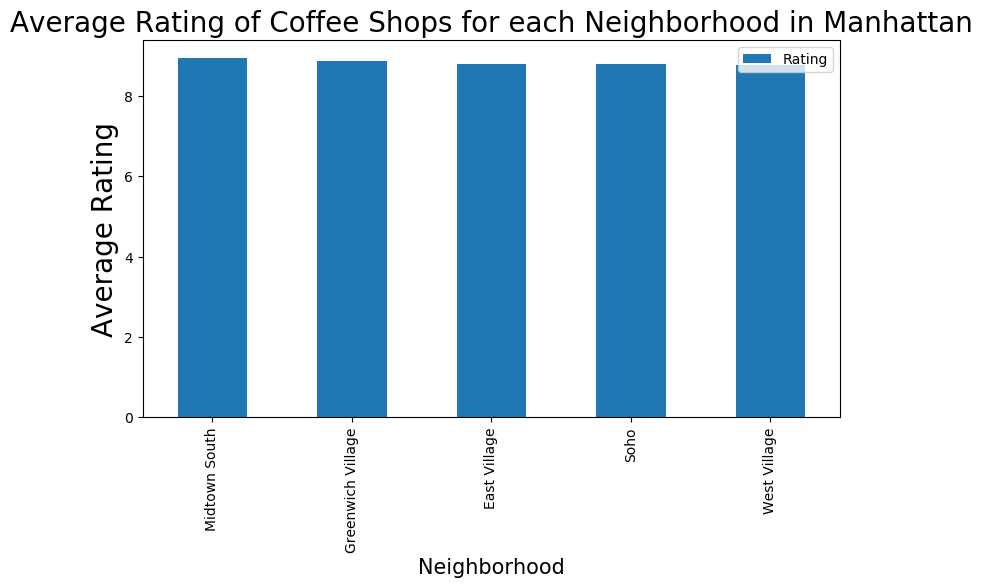

In [121]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average Rating of Coffee Shops for each Neighborhood in Manhattan', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Average Rating', fontsize= 20)
manhattan_rate.groupby('Neighborhood').mean()['Rating'].nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

# Create dataframe with average rating greater than 6

In [123]:
neighborhood_stats_rating = neighborhood_stats[neighborhood_stats['Average Rating']>=6.0]
neighborhood_stats_rating.shape

(38, 2)

# Merge ratings dataframe and coordinate dataframe

In [132]:
neighborhood_stats_rating = pd.merge(neighborhood_stats_rating, manhattan_data, on='Neighborhood')
neighborhood_stats_rating=neighborhood_stats_rating[['Borough', 'Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats_rating.tail()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
33,Manhattan,Upper East Side,40.775639,-73.960508,8.357143
34,Manhattan,Upper West Side,40.787658,-73.977059,8.375000
35,Manhattan,Washington Heights,40.851903,-73.936900,7.450000
36,Manhattan,West Village,40.734434,-74.006180,8.775000
37,Manhattan,Yorkville,40.775930,-73.947118,7.900000


# Plot location of coffee shops in Manhattan with name and ratings

In [135]:
from geopy.geocoders import Nominatim
from folium import plugins

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

#start with clean copy of NYC map
manhattan_map = folium.Map(location=[latitude, longitude], zoom_start=11)

manhattan_rate = plugins.MarkerCluster().add_to(manhattan_map)

neighborhood_stats_rating['Label']= neighborhood_stats_rating['Neighborhood']+'('+neighborhood_stats_rating['Average Rating'].map(str)+')'
#loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in neighborhood_stats_rating[['Latitude','Longitude','Label']].values:
    folium.Marker(
        location=[lat,lng],
        icon=None,
        popup=label).add_to(manhattan_rate)
    
    
manhattan_map

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.
